# OBIA4RTM - Analysis and Visualisation

------------------------------------------------------------------------------------------------------------------------

**Author** Lukas Graf, University of Salzburg, Winter-Term 2019/2020

This notebook provides some insights into the data and results generated during the *integrated project I3* "OBIA4RTM - Object-Based Plant Parameter Retrieval Using Radiative Transfer Models".

The data used in this notebook is entirly stored in a PostgreSQL/PostGIS database. A dump of the database is available in the Gitlab repository.

All data in this subject is subject to the CC-BY-NC license agreement. The in-situ data used for validation purposes was collected at LMU Munich (Department of Geography) in 2017.

You can re-run the notebook on your own device and modify it. Make sure to have **Python-3** installed and running on your machine. Probabbly, you also habe to install further Python packages such as *psycopg2, numpy, pandas, folium, matplotlib, seaborn*.

### Table of Content:
* [1) Exploring in-situ Data](#first-bullet)
* [2) Exploring Sentinel-2 Satellite Data](#second-bullet)
* [3) Setting up the Radiative Transfer Model ProSAIL](#third-bullet)
* [4) Running ProSAIL Simulates and Performing the Inversion](#fourth-bullet)
* [5) Validation of Derived Leaf Area Data](#fifth-bullet)
* [6) Further Quality Assessment](#sixth-bullet)
* [7) Do it yourself!](#eigth-bullet)


========================================================================================================================

## 1) Exploring in-situ Data <a name="first-bullet"></a>

### Summary

This section covers the following aspects:

- Overview of the in-situ data used for validating the OBIA4RTM approach

- Overview of the study area

- time series plots of the insitu showing the temporal characteristics of crop development

### Highlights

- 21 field measurements of leaf area index (LAI) availabe between March and August 2017

- 5 fields covered by insitu inspections with three different crop types, i.e. maize silage, winter wheat and winter triticale

-----------------------------------------------------------------------------------------------------------------------

### Leaf Area Index (LAI)
In-situ data of three different crop types - **winter wheat, winter triticale and maize silage** - was available for the year 2017 covering the length of one growing season at five different field plots. The measurements were conducted on behalf of the Department of Geography of the Ludwig-Maximilians-University Munich. Among other plant parameters, the leaf area index (LAI) was determined using a [LAI-2200C Plant Canopy Analyzer](https://www.licor.com/env/products/leaf_area/LAI-2200C/).

The LAI is a dimensionless biophysical variable that is defined as the one-sided area of green leaves per ground unit (Maddoni & Otegui, 1996). It is an important proxy for the mass and enery transfer between plants and the atmosphere and therefore a highly required input to precision farming applications and climate change studies.

During, 2017, several in-situ measurements were collected at the points shown in the **interactive map** below:

In [2]:
# import folium to display leaflet in Jupyter
import folium
import json
import requests
from branca.element import Template, MacroElement

m = folium.Map(location=[48.28, 11.7], zoom_start=13)
# include the in-situ data into the leaflet
url = r"https://raw.githubusercontent.com/lukasValentin/OBIA4RTM/master/Examples/data/GEOJSON/"
# field boundaries
field_boundaries = json.loads(requests.get(f'{url}/multiply_sample-fields_2017.geojson').text)
# sample points of Multiply compaign 2017
sample_points = json.loads(requests.get(f'{url}/multiply_sample-points_2017.geojson').text)

# add to leaflet map
ma = folium.GeoJson(# 
    field_boundaries,
    name='Field Boundaries 2017',
    style_function=lambda x: {'fillColor':'darkgreen' if x['properties']['USE'] == 'Winter Wheat'
else 'yellow' if 'Maize' == x['properties']['USE'] else 'purple', 'fillOpacity': 0.5}
)
ma.add_to(m)

#  sample_points Multiply 2017 (with popups)
sp = folium.GeoJson(
    sample_points,
    name='Multiply Sample Points 2017')
sp.add_child(folium.Popup('Sample Point 2017'))
sp.add_to(m)

# add a legend
# found on: https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd (24.11.19)
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Crop Types 2017</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:darkgreen;opacity:0.7;'></span>Winter Wheat</li>
    <li><span style='background:yellow;opacity:0.7;'></span>Maize Silage</li>
    <li><span style='background:purple;opacity:0.7;'></span>Winter Triticale</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

# add a layer control to the leaflet
folium.LayerControl(collapsed=True).add_to(m)
# see https://python-visualization.github.io/folium/quickstart.html#Getting-Started
m
# save the leaflet
# m.save('study_area.html')

----------------------------------------------------------------------------------------------------------------------

### Time Series of LAI
As a first step, the dates at which insitu measurements were carried are displayed. Therefore, it is necessary to connect to the OBIA4RTM database where the in-situ data is stored and load some Python packages required for plotting the data:

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import psycopg2

# define a function to open and close database connection
def connect_db():
    """function to get a connection and cursor object for querying OBIA4RTM database"""
    database = "obia4rtm_test"
    username = "postgres"
    password = "12345"
    host = "localhost"
    port = 5432
    # open the connection
    connection = psycopg2.connect(
        dbname=database,
        user=username,
        password=password,
        host=host,
        port=port
    )
    # get a cursor
    cursor = connection.cursor()
    return connection, cursor

# define a function for close the database connection
def close_db_connection(con, cursor):
    """close the database connection"""
    if con.closed != 0:
        cursor.close()
        con.close()

# open database connection
con, cursor = connect_db()
register_matplotlib_converters()

**Query** the available insitu measurments and list them in a pandas dataframe.

In [3]:
# query the acquisition dates
query = "select distinct (to_date(date,'MM-DD-YYYY')) from validation.multiply_lai_2017 "\
        "order by to_date(date,'MM-DD-YYYY') ;"
cursor.execute(query)
res = pd.DataFrame(cursor.fetchall())
res.columns = ['in-situ measurement dates (mm-dd-yyyy)']

# display the acquisition dates
res

,in-situ measurement dates (mm-dd-yyyy)
0,2017-03-24
1,2017-03-28
2,2017-04-05
3,2017-04-10
4,2017-04-21
5,2017-05-02
6,2017-05-10
7,2017-05-16
8,2017-05-26
9,2017-05-29


The data covers an entire growing period starting at the end of March 2017 until the end of August with 20 measurement dates available. Thus, there is a very high temporal density of the insitu data making it suited for studying crop development in terms of LAI over time.

Next, the measured leaf area values can be plotted for each of the five fields. The field plots are identified by IDs. The following crops were grown per field in 2017:

In [2]:
# select the ID and crop type from the sample fields
query = "select id, use from validation.multiply_fields_2017;"
cursor.execute(query)
res = pd.DataFrame(cursor.fetchall())
res.columns = ['field-id', 'crop-type']

# display the dataframe
res

,field-id,crop-type
0,319,Maize
1,515,Maize
2,542,Winter Triticale
3,301,Winter Triticale
4,508,Winter Wheat


The in-situ measurements cover different yield zones (termed as "low", "medium" and "high") within the single fields to account for spatial variation of within-field crop growing conditions. Therefore, for each field the LAI development over time for each of the three yield zones is displayed below. In addition, the mean and standard deviation per date and field is drawn to visualize the amount of intra-field variation of the LAI:

/home/lukas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


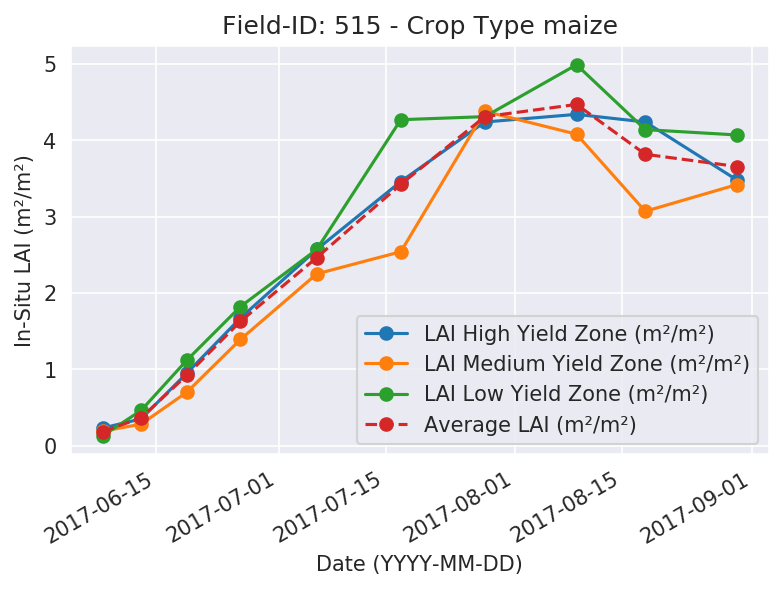

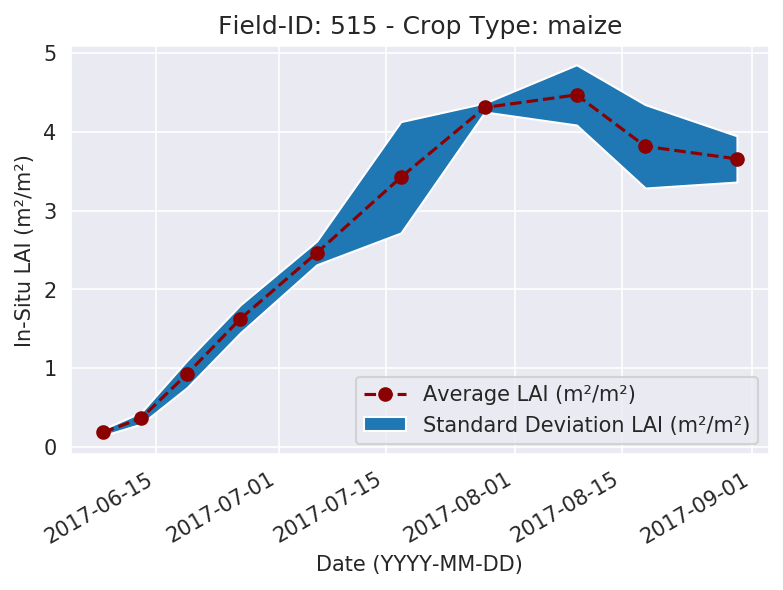

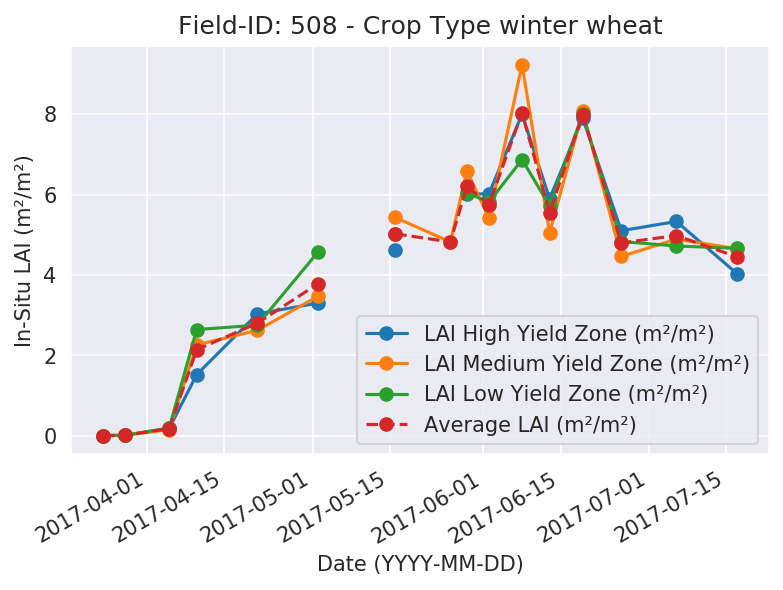

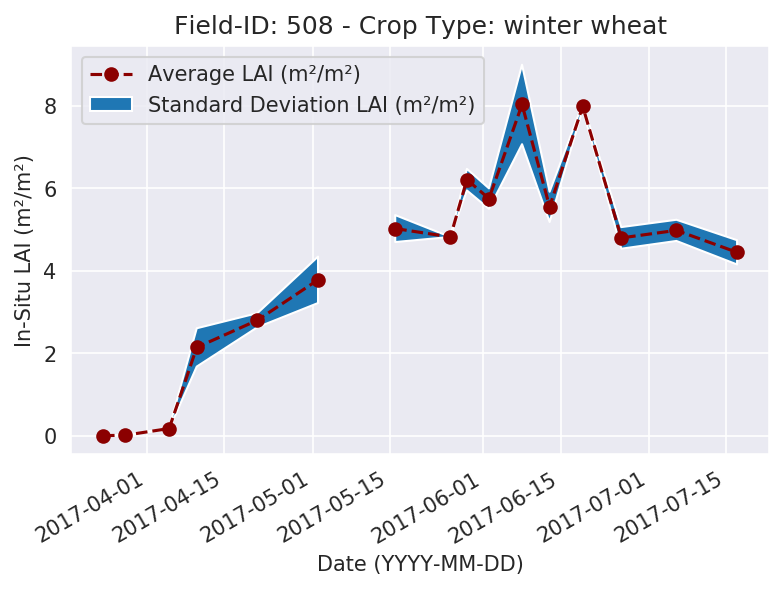

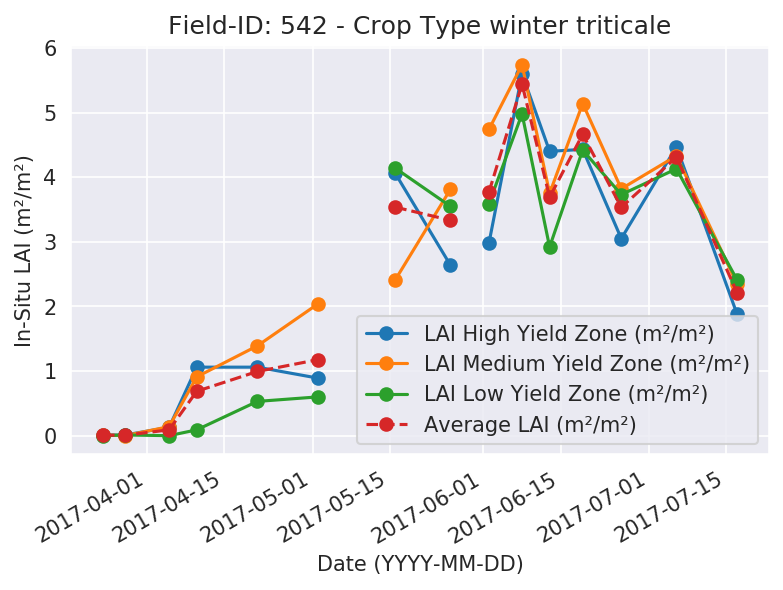

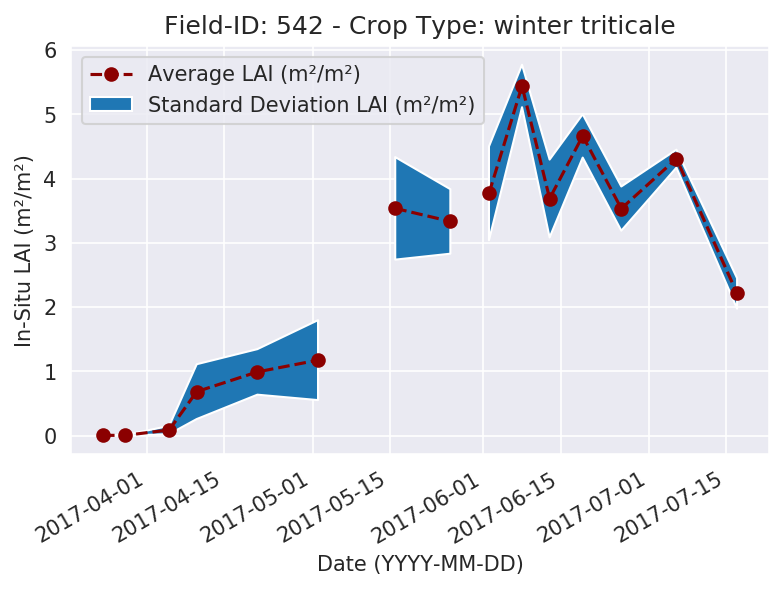

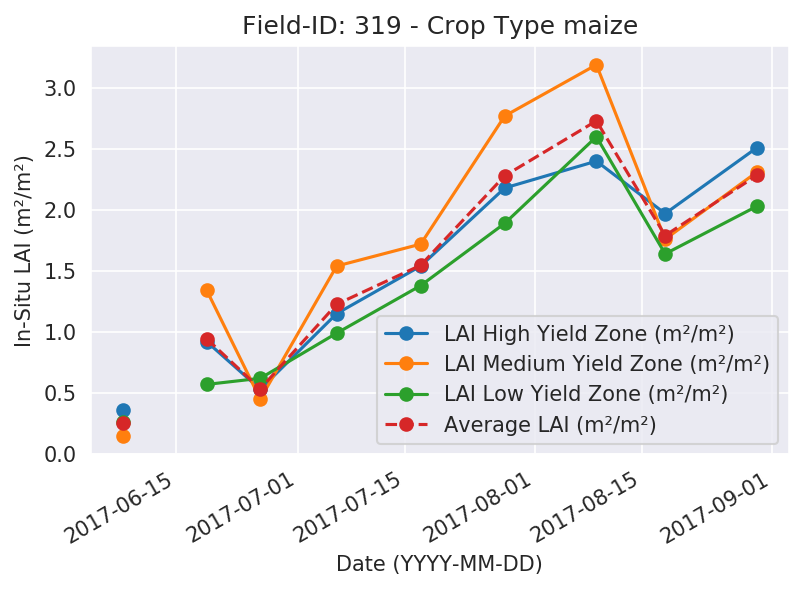

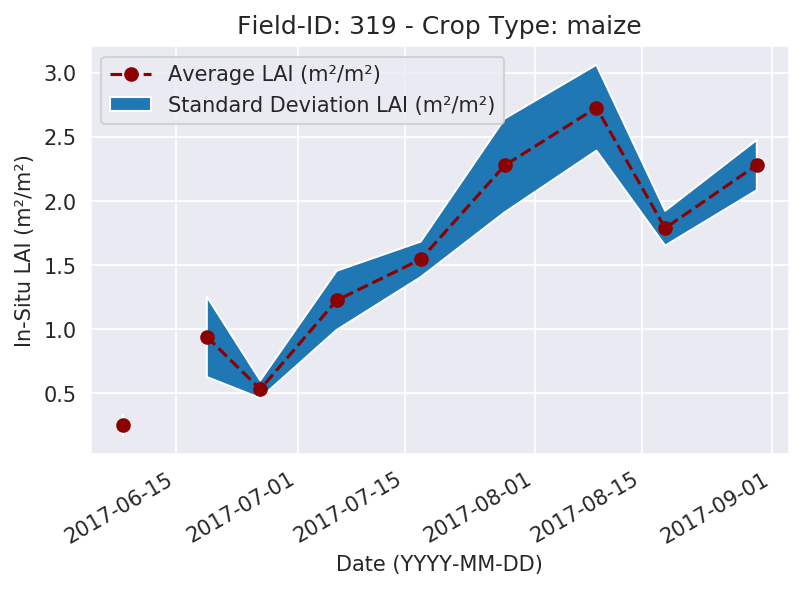

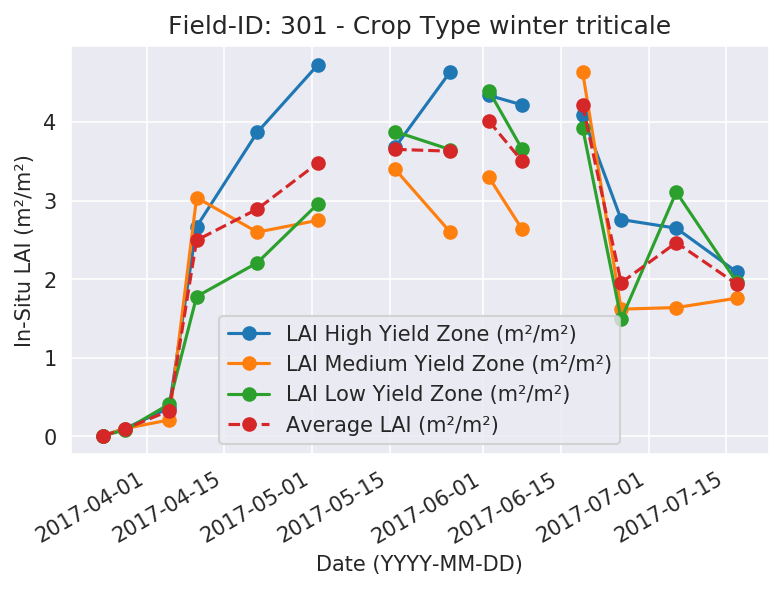

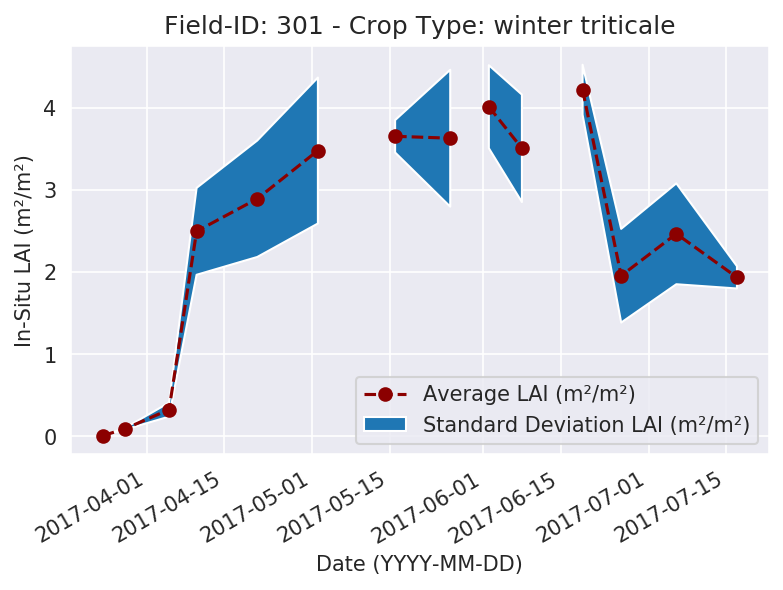

In [4]:
%matplotlib inline  
ids = [515, 508, 542, 319, 301]
crops = ['maize', 'winter wheat', 'winter triticale', 'maize', 'winter triticale']
sns.set_style('darkgrid')

# loop over the field plots and plot the in-situ measured lai values
jj = 0
for _id in ids:
    # high yield zone
    query = "select lai from validation.multiply_lai_2017 "\
            "where id = {} and esu = 'high' order by to_date(date,"\
            "'MM-DD-YYYY') ;".format(_id)
    cursor.execute(query)
    lai_high = cursor.fetchall()
    lai_high = [x[0] if x[0] >= 0 else np.nan for x in lai_high]

    # medium yield zone
    query = "select lai from validation.multiply_lai_2017 "\
            "where id = {} and esu = 'medium' order by to_date(date,"\
            "'MM-DD-YYYY') ;".format(_id)
    cursor.execute(query)
    lai_medium = cursor.fetchall()
    lai_medium = [x[0] if x[0] >= 0 else np.nan for x in lai_medium]

    # low yield zone
    query = "select lai from validation.multiply_lai_2017 "\
            "where id = {} and esu = 'low' order by to_date(date,"\
            "'MM-DD-YYYY') ;".format(_id)
    cursor.execute(query)
    lai_low = cursor.fetchall()
    lai_low = [x[0] if x[0] >= 0 else np.nan for x in lai_low]

    query = "select distinct to_date(date,'MM-DD-YYYY') as dates "\
            "from validation.multiply_lai_2017 where id = {} order by "\
            "dates;".format(_id)
    cursor.execute(query)
    dates = cursor.fetchall()
    dates = [x[0] for x in dates]

    # average lai -> calculate from "low", "medium" and "high" yield zone
    # to the some for the standard deviation
    avg = []
    std_lower = []
    std_upper = []
    for ii in range(len(dates)):
        temp = [lai_high[ii], lai_medium[ii], lai_low[ii]]
        avg.append(np.nanmean(temp))
        std_upper.append(avg[ii] + np.nanstd(temp))
        std_lower.append(avg[ii] - np.nanstd(temp))

    # plot all lai curves
    f = plt.figure(dpi=150)
    ax = f.add_subplot(111)
    ax.plot(dates,lai_high, label='LAI High Yield Zone (m²/m²)', marker='o')
    ax.plot(dates,lai_medium, label='LAI Medium Yield Zone (m²/m²)', marker='o')
    ax.plot(dates,lai_low, label='LAI Low Yield Zone (m²/m²)',  marker='o')
    ax.plot(dates,avg, label='Average LAI (m²/m²)', linestyle='dashed', marker='o')
    f.autofmt_xdate()
    ax.set_xlabel('Date (YYYY-MM-DD)')
    ax.set_ylabel('In-Situ LAI (m²/m²)')
    ax.set_title('Field-ID: {0} - Crop Type {1}'.format(_id, crops[jj]))
    ax.legend()

    # plot mean and standard deviation only
    f2 = plt.figure(dpi=150)
    ax = f2.add_subplot(111)
    ax.fill_between(dates,std_lower,std_upper, label='Standard Deviation LAI (m²/m²)')
    ax.plot(dates,avg, label='Average LAI (m²/m²)', linestyle='dashed', marker='o', color='darkred')
    f2.autofmt_xdate()
    ax.set_xlabel('Date (YYYY-MM-DD)')
    ax.set_ylabel('In-Situ LAI (m²/m²)')
    ax.set_title('Field-ID: {0} - Crop Type: {1}'.format(_id, crops[jj]))
    ax.legend()
    # increase counter manually
    jj = jj + 1

The crop types show a distinct temporal pattern in terms of LAI development and the deviation among the different yield zones.

**Winter wheat and winter triticale** show higher maximum lai values (> 6 m²/m²) than **maize** (< 5 m²/m²) which is a result of the canopy architecture. While maize plants tend to grow much higher than wheat or triticale, the density of leaves is much lower. Moreover, winter wheat and tritical reach the maximum LAI much earlier in the year (around end of June) than maize plants (around August). This because of the late sowing date of maize that is usually around the beginning to mid of May. Winter crops such as winter wheat start growing usually in the autumn before the current growing season and reach maturity therefore much earlier than summer crops such as maize.

========================================================================================================================

## 2) Exploring Sentinel-2 Satellite Data <a name="second-bullet"></a>

### Summary

- description of the optical Sentinel-2 remote sensing platform

- examples of plant spectra of the studied field plots at different points in time reflecting changes in crop canopy architecture and phenology

### Highlights

- Sentinel-2 timelaps of the study area covering all available scenes in 2017

- example plant spectra showing influence of canopy architecture and phenology on spectral reflectance properties of crops

- NDVI time series showing the development of the five field plots as seen from space

- empirical NDVI-LAI relationship

-------------------------------------------------------------------------------------------------------------------

### Sentinel-2

Sentinel-2 is a optical remote sensing platform currently consisting of twin-constellation, Sentinel-2A and Sentinel-2B. Sentinel-2 has 13 spectral channels ("bands") that acquire spectral information between 400 and 2500 nm. Out of these 13 bands, nine have proven most useful for agricultural applications as atmospheric effects are moderate. Thus, only the following Sentinel-2 bands (wavelengths and bandwidths shown for Sentinel-2A only) are used in this study: 

Band Number  |	Central wavelength (nm)	|  Bandwidth (nm)  |  Spatial resolution (m)
-----------  |  ----------------------- |  --------------  |  ----------------------
2    |	492.4  |	66	| 10
3    |	559.8  |	36	| 10
4    |	664.6  |	31	| 10
5    |	704.1  |	15	| 20
6    |	740.5  |	15	| 20
7    |	782.8  |	20	| 20
8a   |	864.7  |	21	| 20
11   |	1613.7 |	91	| 20
12   |	2202.4 |	175	| 20

For the time period covered by the in-situ measurements, cloud-free Sentinel-2 scenes were searched that could be used to run the OBIA4RTM software tool for the five selected field plots. Therefore, the Sentinel-2 archive available on Google Earth Engine was queried to identify all those scenes available for the outlined period in 2017 with less than 20 percent cloud cover.

The script is available [here](https://code.earthengine.google.com/501cc6eccdb8d3c262ad72e78a158f5a) and can be used with a valide Google Earth Engine account. The script found 16 dates, at which cloud-free Sentinel-2A images are available from Sentinel-2 granule 32UPU:

|num| date (YYYY-MM-DD) |
|---|:------------------|
| 0 | 2017-04-24 |
| 1 | 2017-05-17 |
| 2 | 2017-05-27 |
| 3 | 2017-06-03 |
| 4 | 2017-06-13 |
| 5 | 2017-06-26 |
| 6 | 2017-07-06 |
| 7 | 2017-07-13 |
| 8 | 2017-08-05 |
| 9 | 2017-08-15 |
|10 | 2017-08-22 |
|11 | 2017-08-25 |
|12 | 2017-09-04 |
|13 | 2017-09-21 |
|14 | 2017-10-14 |
|15 | 2017-12-13 |

All acquisition dates were used but the last three, which are not covered by in-situ observations any more. Thus, **13 Sentinel-2A (S2A) scenes were used in sum for this study**. This information was used together with the bounding box covering all five field plots to pre-process all the identified scenes using the 6S atmospheric transfer model to convert Sentinel-2 data in L1C into L2A (bottom-of-atmosphere reflectance).

------------------------------------------------------------------------------------------------------------------------

### Sentinel-2 Timelaps

For visualising the temporal dynamics, a timelaps showing the Sentinel-2 data available for the study area in 2017 was generated using Google Earth Engine.

*include timelaps*

In [47]:
# include the mp4 video
# there might be some browser issues in here
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="/img/Multiply-Example.mp4" type="video/mp4">
</video></div>""")

The timelaps shows how crops are starting in growing at the end of winter and becoming greener towards the summer. While there is some soil visible at the beginning of spring, during summer all plots are covered by plants. Around mid of July to beginning of August, harvesting activities are starting because crops are maturing. Thus, fields become brown as plants are aging and bare soil is visible again after crops and crop residuues have been removed from the fields in autumn. Then, some fields are getting green again due to winter greening activities and winter crops.


------------------------------------------------------------------------------------------------------------------------
### Used Sentinel-2 Scenes

More details on how the OBIA4RTM processing workflow works can be found ....

The most important **metadata** provided by Copernicus were extracted and stored in the OBIA4RTM data base for each pre-processed Sentinel-2 scene. For setting up the ProSAIL model, the viewing and illuminination geometry are essential as these properties influence the spectral reflectance properties of crop canopies:

In [11]:
# query the metadata stored in the OBIA4RTM database (just part of the whole metadata available in the database)
query = "select acquisition_time, sun_zenith, obs_zenith, rel_azimuth, "\
        "sensor from public.scene_metadata where acquisition_time between '2017-01-01' "\
        "and '2017-12-31' order by acquisition_time;"
cursor.execute(query)
res = pd.DataFrame(cursor.fetchall())
res.columns = ['Acquisition Time', 'Sun Zenith Angle',
               'Observer Zenith Angle', 'Relative Azimuth Angle', 'Sensor']
res

,Acquisition Time,Sun Zenith Angle,Observer Zenith Angle,Relative Azimuth Angle,Sensor
0,2017-04-24T10:11:20.04sZ,37.132648,8.766354,51.107819,S2A
1,2017-05-17T10:23:52.05sZ,30.197464,4.833664,112.480962,S2A
2,2017-05-27T10:23:01.05sZ,28.372595,4.823562,113.703076,S2A
3,2017-06-03T10:10:26.06sZ,28.212421,8.776897,45.793852,S2A
4,2017-06-13T10:16:08.06sZ,27.554991,8.791754,44.202120,S2A
5,2017-06-26T10:23:21.06sZ,26.888233,4.736701,116.133996,S2A
6,2017-07-06T10:23:01.07sZ,27.690516,4.748416,116.459919,S2A
7,2017-07-13T10:11:19.07sZ,29.402800,8.790229,42.771505,S2A
8,2017-08-05T10:25:35.08sZ,33.285213,4.824957,115.181485,S2A
9,2017-08-15T10:25:13.08sZ,36.011864,4.835924,113.345267,S2A


As in-situ dates and satellite acquisition dates slightly differ, a time difference of +/- 5 days was allowed between the in-situ measurements and the satellite image acquisitions. Within 5 days, only minor changes in plant canopies are assumed to appear (under average growing conditions).

To assess the overlapping dates, a temporal gap of +/- 5 days was allowed:

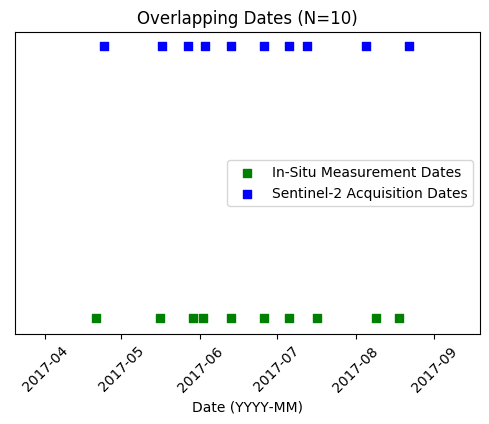

In [3]:
# find out how many overlapping dates between in-situ and satellite observations exist:
query = """select distinct on(s2.acquisition_date)
                to_date(insitu.date,'MM-DD-YYYY')::DATE,
                s2.acquisition_date::DATE
            from
                validation.multiply_lai_2017 as insitu,
                obia4rtm_sentinel_2.s2_obj_spectra as s2
            where
                age(to_date(insitu.date,'MM-DD-YYYY')::DATE, s2.acquisition_date) > '-5 days'
            and
                age(to_date(insitu.date,'MM-DD-YYYY')::DATE, s2.acquisition_date) < '5 days'
            and
                insitu.id = s2.object_id
            order by s2.acquisition_date;"""
cursor.execute(query)
res = pd.DataFrame(cursor.fetchall())
res.columns = ['In-Situ Measurement Date', 'Sentinel-2 Image Acquisition Date']

# make a plot to show the temporal gap and overlap between the insitu dates and the acquisiton dates
res['insitu_y'] = np.ones(res.shape[0]) * 1
res['s2_y'] = np.ones(res.shape[0]) * 2

f = plt.figure(dpi=100)
ax = f.add_subplot(111)
ax.scatter(res['In-Situ Measurement Date'], res['insitu_y'],
         label='In-Situ Measurement Dates', color="green", marker="s")
ax.scatter(res['Sentinel-2 Image Acquisition Date'], res['s2_y'],
         label='Sentinel-2 Acquisition Dates', color="blue", marker="s")
plt.title("Overlapping Dates (N={})".format(res.shape[0]))
ax.set_xlabel("Date (YYYY-MM)")
ax.set_yticks([],[])
plt.xticks(rotation=45)
plt.legend()
plt.show()

Thus, **10 observations** fulfil the requirement of having a temporal gap of +/- 5 days (or less) between in-situ measurement and satellite image acquisition date. This is because during early spring in-situ measurements are available but no satellite images (most likely because of clouds) and during August and September the gaps are either too higher or satellite data is available but no in-situ data any more.

------------------------------------------------------------------------------------------------------------------

### Object-based Plant Spectra

As already denoted, OBIA4RTM stores spectra on a per object base in the back-end database. In this case, the five field plots form the image objects. For each image object, the mean reflectance (in percentage) is calculated from the atmospherically corrected imagery.
Based on these steps, it is possible to

- assess spectra per field and acquisition date
- calculate spectral indices (such as the NDVI) and assess their change over time

The first step consists in the analysis of some object spectra:

In [45]:
# choose the table with the image object spectra (i.e single fields)
obj_spec_table = "obia4rtm_sentinel_2.s2_obj_spectra"

# define a function for plotting spectra
def plot_single_spectrum(field_id, acqui_date, obj_spec_table):
    """
    function to plot a single spectrum for a specific field on a specific data
    """
    con, cursor = connect_db()  # open database connection
    # determine which sensor was used and get the according bands
    # get the scene id first and use this to query the bands
    query = "SELECT scene_id FROM {0} WHERE "\
            "object_id = {1} AND acquisition_date = '{2}';".format(
                    obj_spec_table,
                    field_id,
                    acqui_date)
    cursor.execute(query)
    scene_id = cursor.fetchone()[0]
    # the sensor is denoted in the first three characters of the scene id
    sensor = scene_id[0:3]
    # now query the band centers (nm) from the metadata table in the public schema
    query = "SELECT central_wvl FROM public.s2_bands WHERE sensor = '{}' "\
            "ORDER BY central_wvl;".format(
                    sensor)
    cursor.execute(query)
    wvl = cursor.fetchall()
    # unpack the returned tuples into a list
    wvl = [x[0] for x in wvl]
    # get the reflectance values in percentage
    query = "SELECT B2, B3, B4, B5, B6, B7, B8A, B11, B12 FROM {0} WHERE "\
            "object_id = {1} AND acquisition_date = '{2}';".format(
                    obj_spec_table,
                    field_id,
                    acqui_date)
    cursor.execute(query)
    spectrum = cursor.fetchall()[0]
    # unpack the returned tuples into a list
    spectrum = [x for x in spectrum]
    # plot the spectrum
    sns.set_style('darkgrid')
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.plot(wvl, spectrum, marker="o")
    ax.set_title("ID = {0}, '{1}'".format(field_id, acqui_date))
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Surface Reflectance (%)")
    plt.show()

For the first acquisition dates, it is very likely that the spectra look like bare soil - especially in the case of maize:

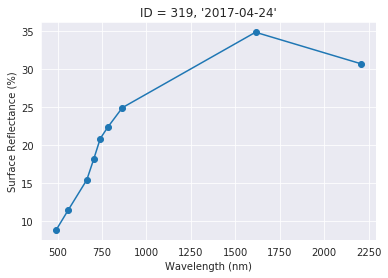

In [46]:
# plot the field with id 319 (maize) for the first acquistion date (24th April 2017)
plot_single_spectrum(field_id=319, acqui_date='2017-04-24', obj_spec_table=obj_spec_table)

In contrast, in June, the same field plot is more vegetated and, thus, the spectrum looks much more like vegetation despite some soil seems still to be visible (thus, canopy is not closed yet).

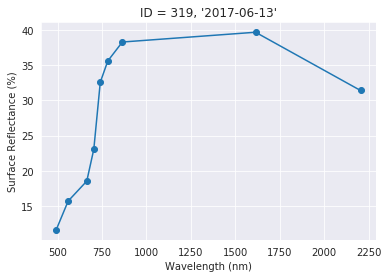

In [47]:
plot_single_spectrum(field_id=319, acqui_date='2017-06-13', obj_spec_table=obj_spec_table)

At the end of the maize growing season, at the maize canopy still looks like green vegetation

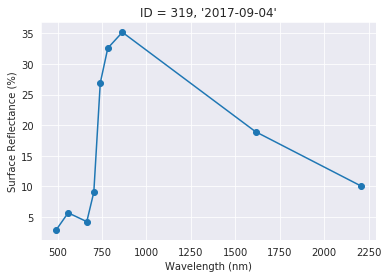

In [48]:
plot_single_spectrum(field_id=319, acqui_date='2017-09-04', obj_spec_table=obj_spec_table)

The same analysis can be done for the **winter wheat** plot (id=508):
At the first acquisition date, the canopy is already very green; no soil is visible (canopy closure).

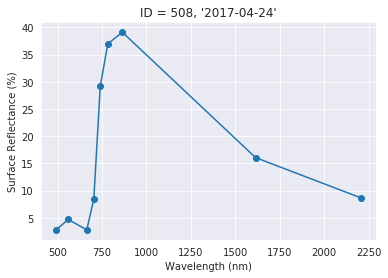

In [49]:
plot_single_spectrum(field_id=508, acqui_date='2017-04-24', obj_spec_table=obj_spec_table)

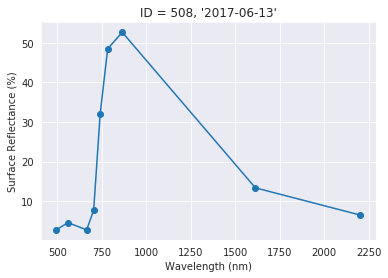

In [50]:
plot_single_spectrum(field_id=508, acqui_date='2017-06-13', obj_spec_table=obj_spec_table)

Towards the end of the winter wheat growing period in mid July, the canopy starts to get more brown as the chlorophyll absorption in the visible bands is decreased:

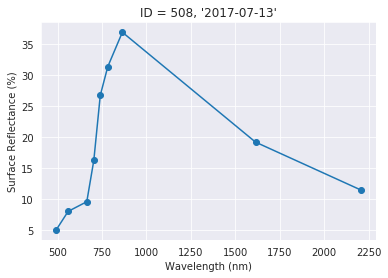

In [51]:
plot_single_spectrum(field_id=508, acqui_date='2017-07-13', obj_spec_table=obj_spec_table)

-------------------------------------------------------------------------------------------------------------------

### NDVI Time Series

To assess the spectral properties changing over time, calculated a spectral index such as **NDVI** defined as the normalized ratio of the RED to NEAR-INFRARED spectral band seems promosing. The NDVI addresses the red-edge shoulder which is a good indicator for the presence of vegetation and its conditions. The NDVI ranges from -1 to 1; the higher the NDVI, the more likely vegetation and the more likely the vegetation is healthy and green.

In [37]:
def plot_ndvi_timeseries(start_date, end_date, object_id, object_table="obia4rtm_sentinel_2.s2_obj_spectra"):
    """
    plot NDVI time series from a specific field provided in the database
    """
    sns.set_style('darkgrid')
    con, cursor = connect_db()  # open database connection
    # gnenerate the sql database query
    sql = "select acquisition_date, (B8A-B4)/(B8A+B4) as NDVI "\
          "from {0} where acquisition_date between '{1}' and '{2}' "\
          "and object_id = {3} order by acquisition_date;".format(
                  object_table,
                  start_date,
                  end_date,
                  object_id)
    cursor.execute(sql)
    res = cursor.fetchall()
    # convert tubles to list
    dates = [x[0] for x in res]     # dates of image acquisition
    ndvi = [x[1] for x in res]      # NDVI values
    f = plt.figure()
    register_matplotlib_converters()
    ax = f.add_subplot(111)
    ax.plot(dates, ndvi, marker="o")
    ax.set_title("NDVI timeseries of Field with ID: {0}".format(object_id))
    ax.set_xlabel("Date (YYYY-MM-DD)")
    ax.set_ylabel("NDVI (-)")
    plt.xticks(rotation=45)
    ax.set_ylim(0.,1.)
    plt.show()

Plot the time series for each field:

#### 508 - Winter Wheat

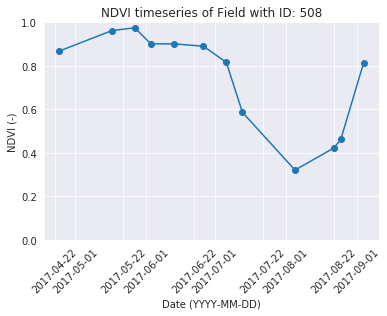

In [38]:
plot_ndvi_timeseries(start_date="2017-04-24", end_date="2017-09-04", object_id=508)

#### 542 - Winter Triticale

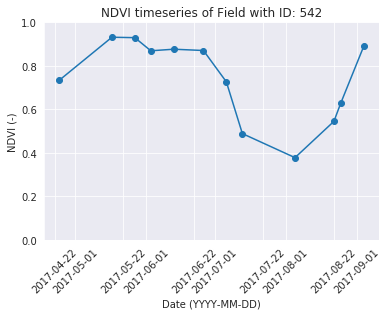

In [39]:
plot_ndvi_timeseries(start_date="2017-04-24", end_date="2017-09-04", object_id=542)

#### 301 - Winter Triticale

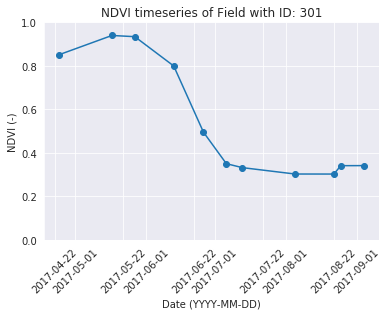

In [40]:
plot_ndvi_timeseries(start_date="2017-04-24", end_date="2017-09-04", object_id=301)

#### 319 Maize

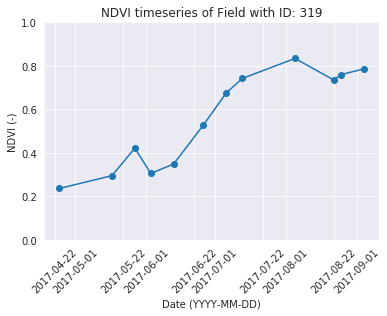

In [41]:
plot_ndvi_timeseries(start_date="2017-04-24", end_date="2017-09-04", object_id=319)

#### 515 Maize

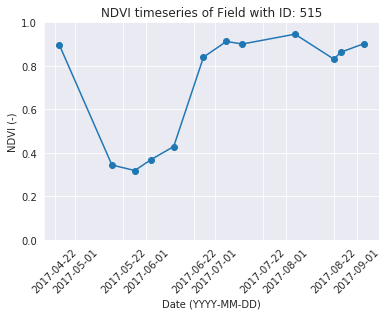

In [42]:
plot_ndvi_timeseries(start_date="2017-04-24", end_date="2017-09-04", object_id=515)

The object-based NDVI time series give some first valuable insights into crop growth:

- winter wheat and winter triticale have a very similar temporal pattern in NDVI values: they reach maximum NDVI values in early summery (June). LAI values drop significantly towards mid of July/ beginning of August, indicating that crops are maturing and are finally harvested around the end of July

- maize NDVI values are very low at the beginning of the observed period as no maize plants are growing. In case of field 515 most likely the cultivation of catch crops caused the high values in April which dropped after the catch crops were removed to seed maize in May. NDVI of maize were still high at the beginning of September indicating that the canopy was still very green at this moment in time (this is also supported by the spectral signature displayed for one maize field at the last acquisition date)

--------------------------------------------------------------------------------------------------------------------

### Emprical NDVI-LAI Relationship

A further commonly used statisitcal measure is to draw the scatter-plot between the in-situ measured LAI and the corresponding NDVI values: All object-based NDVI within a temporal window around +/- 5 days around a LAI measurement were analysed and visualized as scatterplot:

In [7]:
query = """
        select
            insitu.lai,
            (s2.B8A - s2.B4)/(s2.B8A + s2.B4) as NDVI
        from
            validation.multiply_lai_2017 as insitu,
            obia4rtm_sentinel_2.s2_obj_spectra as s2
        where
            age(to_date(insitu.date,'MM-DD-YYYY')::DATE, s2.acquisition_date) > '-5 days'
        and
            age(to_date(insitu.date,'MM-DD-YYYY')::DATE, s2.acquisition_date) < '5 days'
        and
            insitu.id = s2.object_id;
        """
cursor.execute(query)
res = pd.DataFrame(cursor.fetchall())
res.columns = ['in-situ measured LAI', 'object-based NDVI']

In [8]:
# drop -999 values in the in-situ data
res[res['in-situ measured LAI'] < 0] = np.nan
# assess the correlation
res.corr()

,in-situ measured LAI,object-based NDVI
in-situ measured LAI,1.000000,0.582932
object-based NDVI,0.582932,1.000000


Text(0, 0.5, 'object-based NDVI (-)')

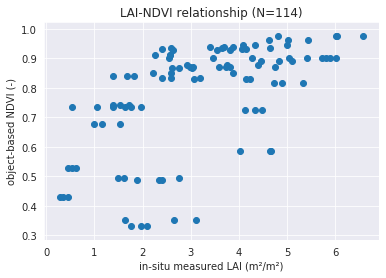

In [9]:
sns.set_style('darkgrid')
plt.scatter(res['in-situ measured LAI'], res['object-based NDVI'])
plt.title("LAI-NDVI relationship (N={})".format(res.shape[0]))
plt.xlabel("in-situ measured LAI (m²/m²)")
plt.ylabel("object-based NDVI (-)")

This analysis shows that higher LAI values go ahead with higher NDVI values. Furthermore, the plot above reveals a saturation effect commonly visible when assessing the LAI-NDVI relationship. While LAI values are still increasing, the NDVI remains constantly high close to 1. Thus, building a statistical relationship between the LAI and the NDVI for retrieving the former seems not sufficient, as the NDVI cannot provide the necessary spectral information about the canopy.

========================================================================================================================

## 3) Setting up the Radiative Transfer Model ProSAIL <a name="third-bullet"></a>

In order to retrieve LAI values from the Sentinel-2 imagery, the radiative transfer model ProSAIL model is used. It is comprised of the leaf model **Prospect-5** that models the optical properties of single leaves, and the canopy model **SAIL**. More information about ProSAIL as well as the source code can be found [here](http://teledetection.ipgp.jussieu.fr/prosail/). In the case of OBIA4RTM a Python interface - called prosail - is used to call the ProSAIL model that is written in Fortran programming language. A documentation of the Python interface is available [here](https://pypi.org/project/prosail/).

Setting up the ProSAIL model is a crucial part of the whole workflow as an inadequate parametrization of the different crop types will most likely result in poor inversion performance. This due to inversion process during which simulated spectra are compared to observed ones and the closest match is used as result (see next section). If the simulated spectra do not match the observed spectra at all, even the closest match will have a very large error and, thus, results might not be very useful.

As the crops grown in the study area, differ in their canopy and leaf structure, two different parameterizations were setup:

- one parameterization for winter wheat and winter triticale as these are very similar

- one parameterization for maize silage

- one parameterization for bare soil for those dates where no plants are growing on a field (not used further)

To set up the variables and their range of values, the data provided by [Danner et al.](https://doi.org/10.3390/rs11101150) was used the reported statistics referred to exactly the used study area. Thus, all biophysical and biochemical variables required to parameterize the ProSAIL model are based on in-situ measurements either in the field or in the laboratory. For both parameterization, LAI values were altered as the LAI was the biophysical variable of interest. Looking and illumination angles were derived from the extracted Sentinel-2 metadata.

The parameters are either kept constant or altered using one of the following distribution laws:

- Truncated Gaussian distribution (Gaussian distribution with mean and standard deviation cut to user-defined maximum and minimum values)

- Uniform Distribution between minimum and maximum value

Finally, the following parameterization was used to run ProSAIL for each crop type and each acquisition date:

In [76]:
import wget
# get the utilized ProSAIL parameterization
url = r"https://raw.githubusercontent.com/lukasValentin/OBIA4RTM/master/Examples/data/OBIA4RTM_CFG/prosail.txt"
# use wget to download the data (will be stored in the current working directory this notebook is running)
filename = wget.download(url)

In [120]:
# read in the data
parameters = np.genfromtxt(filename, delimiter="\t")
# convert to dataframe
maize = pd.DataFrame(parameters[13:26,:])
winter_wheat = pd.DataFrame(parameters[26:39,:])
colnames = ['Minimum', 'Maximum', 'Number of Samples', 'Distribution', 'Mean', 'Std', 'Parameter']
maize.columns = colnames
winter_wheat.columns = colnames
# replace the distribution codes by names
maize.loc[maize['Distribution'] == 0.0,'Distribution'] = 'NaN'
maize.loc[maize['Distribution'] == 1.0, 'Distribution'] = 'Truncated Gaussian'
maize.loc[maize['Distribution'] == 2.0, 'Distribution'] = 'Uniform'

# parameter names
maize['Parameter Name (Unit)'] = [ 'N (-)',
                                'Chlorophyll a+b (ug/cm²)',
                                'Carotenoid (ug/cm²)',
                                'Fraction Brown (-)',
                                'Equivalent Water Thickness (cm)',
                                'Dry Matter (g/cm²)',
                                'LAI (m²/m²)',
                                'LIDFA (-)',
                                'LIDF B (-)',
                                'Rsoil (-)',
                                'Psoil (-)',
                                'Hot Spot (-)',
                                'Type of Leaf Angle Distr.'
]

In [123]:
maize[['Parameter Name (Unit)','Minimum', 'Maximum', 'Number of Samples', 'Distribution']]

,Parameter Name (Unit),Minimum,Maximum,Number of Samples,Distribution
0,N (-),1.800,1.800,1.0,NaN
1,Chlorophyll a+b (ug/cm²),35.000,60.000,40.0,Truncated Gaussian
2,Carotenoid (ug/cm²),0.000,0.000,1.0,NaN
3,Fraction Brown (-),0.010,0.010,1.0,NaN
4,Equivalent Water Thickness (cm),0.012,0.021,10.0,Truncated Gaussian
5,Dry Matter (g/cm²),0.004,0.004,1.0,NaN
6,LAI (m²/m²),0.200,4.000,30.0,Truncated Gaussian
7,LIDFA (-),45.000,75.000,20.0,Truncated Gaussian
8,LIDF B (-),-0.150,-0.150,1.0,NaN
9,Rsoil (-),0.200,0.200,1.0,NaN


In [124]:
winter_wheat.loc[winter_wheat['Distribution'] == 0.0, 'Distribution'] = 'NaN'
winter_wheat.loc[winter_wheat['Distribution'] == 1.0, 'Distribution'] = 'Truncated Gaussian'
winter_wheat.loc[winter_wheat['Distribution'] == 2.0, 'Distribution'] = 'Uniform'
# parameter names
winter_wheat['Parameter Name (Unit)'] = [ 'N (-)',
                                'Chlorophyll a+b (ug/cm²)',
                                'Carotenoid (ug/cm²)',
                                'Fraction Brown (-)',
                                'Equivalent Water Thickness (cm)',
                                'Dry Matter (g/cm²)',
                                'LAI (m²/m²)',
                                'LIDFA (-)',
                                'LIDF B (-)',
                                'Rsoil (-)',
                                'Psoil (-)',
                                'Hot Spot (-)',
                                'Type of Leaf Angle Distr.'
]
winter_wheat[['Parameter Name (Unit)','Minimum', 'Maximum', 'Number of Samples', 'Distribution']]

,Parameter Name (Unit),Minimum,Maximum,Number of Samples,Distribution
0,N (-),1.8000,1.8000,1.0,NaN
1,Chlorophyll a+b (ug/cm²),20.0000,60.0000,25.0,Truncated Gaussian
2,Carotenoid (ug/cm²),0.0000,0.0000,1.0,NaN
3,Fraction Brown (-),0.0000,0.8000,10.0,Truncated Gaussian
4,Equivalent Water Thickness (cm),0.0030,0.0200,5.0,Truncated Gaussian
5,Dry Matter (g/cm²),0.0047,0.0047,1.0,NaN
6,LAI (m²/m²),0.5000,6.5000,30.0,Truncated Gaussian
7,LIDFA (-),45.0000,80.0000,15.0,Truncated Gaussian
8,LIDF B (-),0.0000,0.0000,1.0,NaN
9,Rsoil (-),0.2000,0.2000,1.0,NaN


========================================================================================================================

## 4) Running ProSAIL Simulates and Performing the Inversion <a name="fourth-bullet"></a>

The actual parameter retrieval (i.e. LAI retrieval) is done in this section using the OBIA4RTM core API. In sum, the simulated ProSAIL spectra stored in the LUT are compared to the observed satellite spectra and the closest match in terms of the RMSE criterion is used as final result.
An exmaple highlighting the workflow is outlined below using the easy-to-use OBIA4RTM processing API that was also used for pre-processing the imagery.

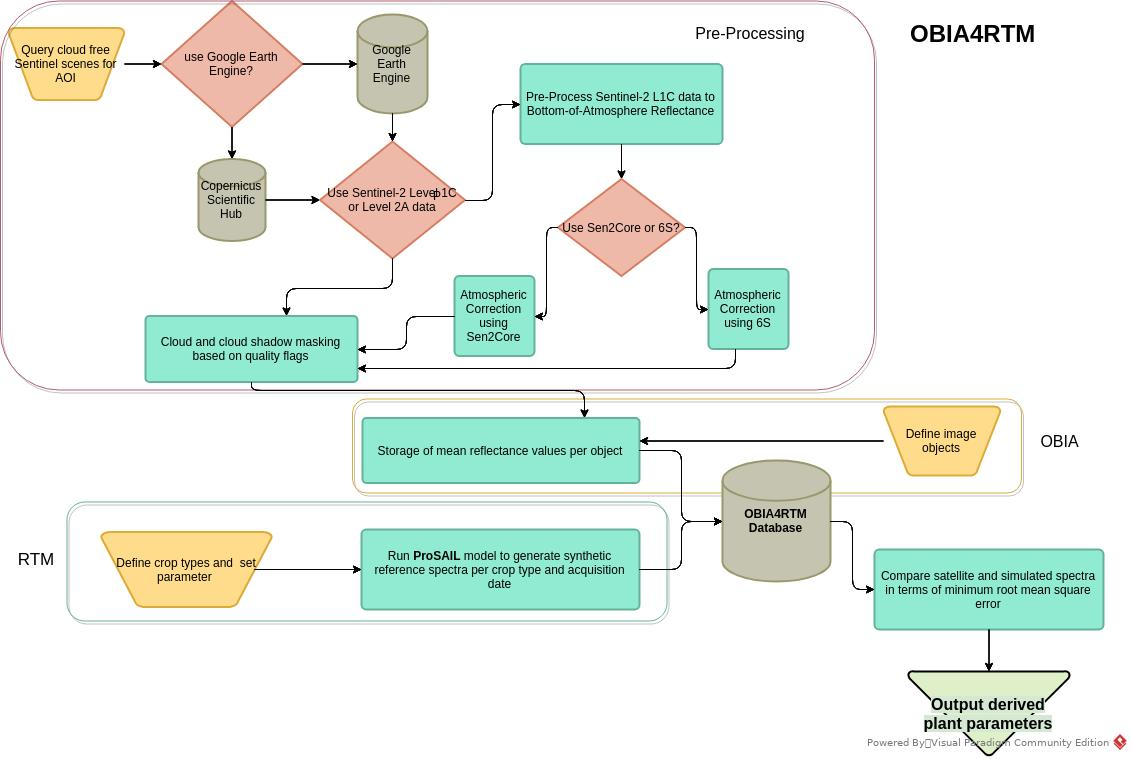

In [35]:
from IPython.display import Image
Image("img/OBIA4RTM-Flowchart.jpg")

In detail, the following steps were applied:

- preprocess Sentinel-2 imagery covering the study area in 2017 with less than 20% cloud coverage using Google Earth Engine client Python API including atmospheric correction using the **6S** model and cloud and cloud shadow masking using the Copernicus-provided **quality flags**

- store the cloud and shadow free spectra on a **per object base** in the database using the average spectrum per field and acquisition date

- set up and run **ProSAIL simulations** (see previous section) taking into account the crop specific plant characterisitics as well as the viewing and illumination geometry per acquisition date

- compare the simulated and observed spectra per acquisition date and field using the root mean squared error as cost function

- the average of the ten closest matches in terms of the **lowest RMSE** are taken as the final result to make the approach more stable

- finally, the satellite-derived plant parameters are written to a new table in the database and are ready for comparison to the in-situ obtained values

========================================================================================================================

## 5) Validation of Derived Leaf Area Data <a name="fifth-bullet"></a>

### Highlights

- good temporal agreement between observed and in-situ measured LAI values in case of winter triticale and to lesser degree in the case of winter wheat
- maize LAI were overestimated during late spring and early summer
- mismatches could be caused by several factors (ProSAIL model parametrization, limited capacities of the ProSAIL model, influence of in-situ sampling strategy, image objects did not reflect within-field heterogeneities accordingly)
- interactive web map showing LAI development over time

------------------------------------------------------------------------------------------------------------------

After the ProSAIL runs are finished it is important to validate the generated results using the available in-situ LAI described above. First, a view in the database is created to allow for comparing in-situ and OBIA4RTM derived LAI values. A maximum temporal gap of 5 days is allowed for comparison.

The LAI data derived from optical Sentinel-2 imagery is either available from the data base (see code snippet below) or can also be queried from the Z_GIS Geoserver using OGC Web Feature Serive (WFS) by using the link http://zgis221.geo.sbg.ac.at/geoserver/I3_OBIA4RTM/wms? in your GIS desktop client or web map application.

In [10]:
# create a new view to store the in-situ and satellite derived LAI values
query = """
CREATE OR REPLACE VIEW validation.s2_lai_validation AS 
 SELECT inversion.object_id ,
    inversion.acquisition_date,
    AVG((inversion.inversion_results ->> 'lai'::text)::double precision) AS sentinel2_lai,
    AVG(insitu.lai) AS insitu_lai
  FROM obia4rtm_sentinel_2.s2_inversion_results inversion,
    validation.multiply_lai_2017 insitu
  WHERE 
    inversion.object_id = insitu.id
  and
   age(to_date(insitu.date,'MM-DD-YYYY')::DATE, inversion.acquisition_date) > '-5 days'
  and
    age(to_date(insitu.date,'MM-DD-YYYY')::DATE, inversion.acquisition_date) < '5 days'
  AND
    insitu.lai >= 0
  GROUP BY inversion.object_id, inversion.acquisition_date
  ORDER BY acquisition_date;

ALTER TABLE validation.s2_lai_validation
  OWNER TO postgres;
"""
cursor.execute(query)
con.commit()

Now, it is possible to query the view in order to validate the generated in-situ data.

First, we can create a scatter plot of the in-situ and Sentinel-2 derived LAI data:

**Scatter-Plot Winter Wheat/ Triticale**

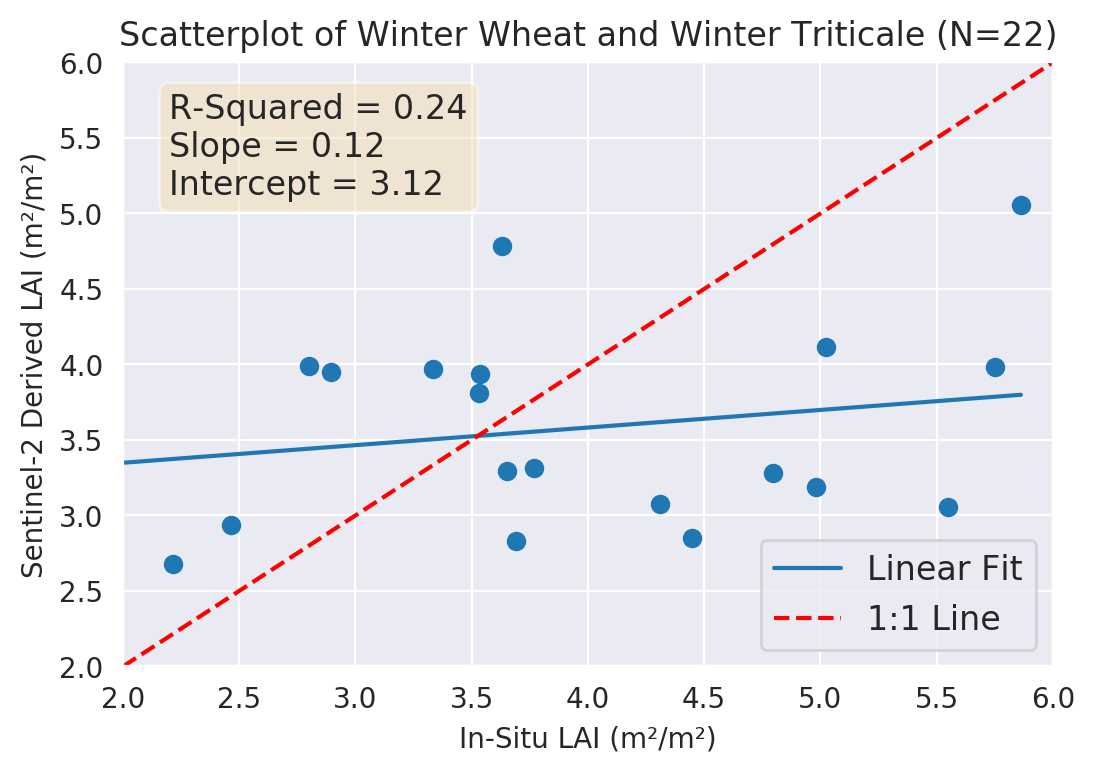

In [2]:
from pylab import polyfit, poly1d
# query the winter wheat and triticale data from the view created above
query = """
SELECT
    insitu_lai, sentinel2_lai
FROM
    validation.s2_lai_validation
WHERE
    object_id IN (542, 301, 508);
"""
cursor.execute(query)
res = pd.DataFrame(cursor.fetchall())
res.columns = ['In-Situ LAI', 'Sentinel-2 LAI']
# make a scatter plot
sns.set_style('darkgrid')
f = plt.figure(dpi=200)
ax = f.add_subplot(111)
ax.scatter(res['In-Situ LAI'], res['Sentinel-2 LAI'])
ax.set_title('Scatterplot of Winter Wheat and Winter Triticale (N={})'.format(res.shape[0]))
ax.set_xlim(2, 6)
ax.set_ylim(2, 6)
ax.set_xlabel('In-Situ LAI (m²/m²)')
ax.set_ylabel('Sentinel-2 Derived LAI (m²/m²)')
# dislay regression line
ax.plot(pd.np.unique(res['In-Situ LAI']), pd.np.poly1d(pd.np.polyfit(res['In-Situ LAI'],
        res['Sentinel-2 LAI'], 1))(pd.np.unique(res['In-Situ LAI'])), label='Linear Fit')
# determine fit parameters
par = pd.np.polyfit(res['In-Situ LAI'], res['Sentinel-2 LAI'], 1, full=True)
slope = par[0][0]
intercept = par[0][1]
rsquared = res.corr()['In-Situ LAI'][1]
# make annotation
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ann_text = 'R-Squared = {0}\nSlope = {1}\nIntercept = {2}'.format(
    pd.np.round(rsquared, 2),
    pd.np.round(slope, 2),
    pd.np.round(intercept, 2))
ax.text(0.05, 0.95, ann_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
# 1:1 line
x = pd.np.linspace(2, 6)
y = x
ax.plot(x, y, color='r', linestyle='--', label='1:1 Line')
ax.legend(loc='lower right', fontsize=12)
plt.show()

#  save res
res_wwwt = res

**R²**

In [12]:
print('R² between In-Situ and Sentinel-2 derived LAI: %5.2f' %(res.corr()['In-Situ LAI'][1]))

R² between In-Situ and Sentinel-2 derived LAI:  0.24


It is obvious that the average in-situ LAI per field and acqusition date and the Sentinel-2 derived values differ and to do not fit the 1:1 line resulting in a low degree of determinination of the linear fit between the two datasets. Sentinel-2 derived values tend to be lower than the in-situ measured LAI values. However, due to the relatively small temporal overlap between the in-situ dates and the image acquisition dates, the population only consists of 16 samples. This renders the scatter plot less representative as it tells nothing about the remaining LAI data and the overall temporal pattern.

**Scatter-plot Maize Silage**

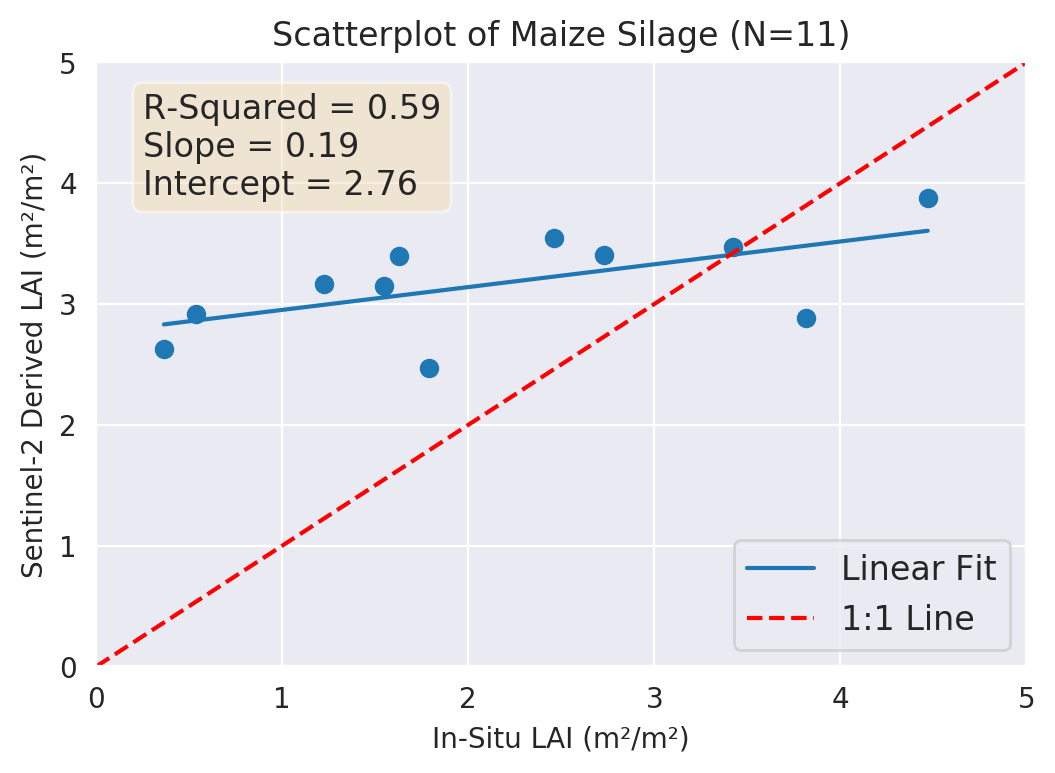

In [3]:
query = """
SELECT
    insitu_lai, sentinel2_lai
FROM
    validation.s2_lai_validation
WHERE
    object_id IN (319, 515);
"""
cursor.execute(query)
res = pd.DataFrame(cursor.fetchall())
res.columns = ['In-Situ LAI', 'Sentinel-2 LAI']
# make a scatter plot
# make a scatter plot
sns.set_style('darkgrid')
f = plt.figure(dpi=200)
ax = f.add_subplot(111)
ax.scatter(res['In-Situ LAI'], res['Sentinel-2 LAI'])
ax.set_title('Scatterplot of Maize Silage (N={})'.format(res.shape[0]))
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xlabel('In-Situ LAI (m²/m²)')
ax.set_ylabel('Sentinel-2 Derived LAI (m²/m²)')
# dislay regression line
ax.plot(pd.np.unique(res['In-Situ LAI']), pd.np.poly1d(pd.np.polyfit(res['In-Situ LAI'],
        res['Sentinel-2 LAI'], 1))(pd.np.unique(res['In-Situ LAI'])), label='Linear Fit')
# determine fit parameters
par = pd.np.polyfit(res['In-Situ LAI'], res['Sentinel-2 LAI'], 1, full=True)
slope = par[0][0]
intercept = par[0][1]
rsquared = res.corr()['In-Situ LAI'][1]
# make annotation
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ann_text = 'R-Squared = {0}\nSlope = {1}\nIntercept = {2}'.format(
    pd.np.round(rsquared, 2),
    pd.np.round(slope, 2),
    pd.np.round(intercept, 2))
ax.text(0.05, 0.95, ann_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
# 1:1 line
x = pd.np.linspace(0, 5)
y = x
ax.plot(x, y, color='r', linestyle='--', label='1:1 Line')
ax.legend(loc='lower right', fontsize=12)
plt.show()

In [14]:
print('R² between In-Situ and Sentinel-2 derived LAI: %5.2f' %(res.corr()['In-Situ LAI'][1]))

R² between In-Situ and Sentinel-2 derived LAI:  0.59


It is also desired to calculate the **`error between in-situ and Sentinel-2 derived LAI`**:

In [6]:
# calculate RMSE and NRMSE between in-situ and Sentinel-2 LAI
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

In [8]:
# WW/WT
rmse_wintercereals = rmse(res_wwwt['In-Situ LAI'], res_wwwt['Sentinel-2 LAI'])
nrmse_wintercereals = rmse_wintercereals / pd.np.nanmean(res_wwwt['In-Situ LAI'])
                
print("Winter Cereals: RMSE={0}, NRMSE={1}".format(rmse_wintercereals, nrmse_wintercereals))

Winter Cereals: RMSE=1.3051845044915957, NRMSE=0.35394470440548254


In [9]:
# Maize
rmse_maize = rmse(res['In-Situ LAI'], res['Sentinel-2 LAI'])
nrmse_maize = rmse_maize / pd.np.nanmean(res['In-Situ LAI'])
                
print("Maize Silage: RMSE={0}, NRMSE={1}".format(rmse_maize, nrmse_maize))

Maize Silage: RMSE=1.4650844480775194, NRMSE=0.6717769457629307


In case of maize, the population size is very small (N=11), therefore, the scatter plot is not sufficient to evaluate the OBIA4RTM LAI retrieval performance. The time series analysis (see next paragraph) is therefore assumed to provide more insights into the appropiatness of the approach.

### Putting everything together
Finally, all three crop types can be plotted in a single, color-coded scatter plot to assess the overall performance of the LAI retrieval strategy.

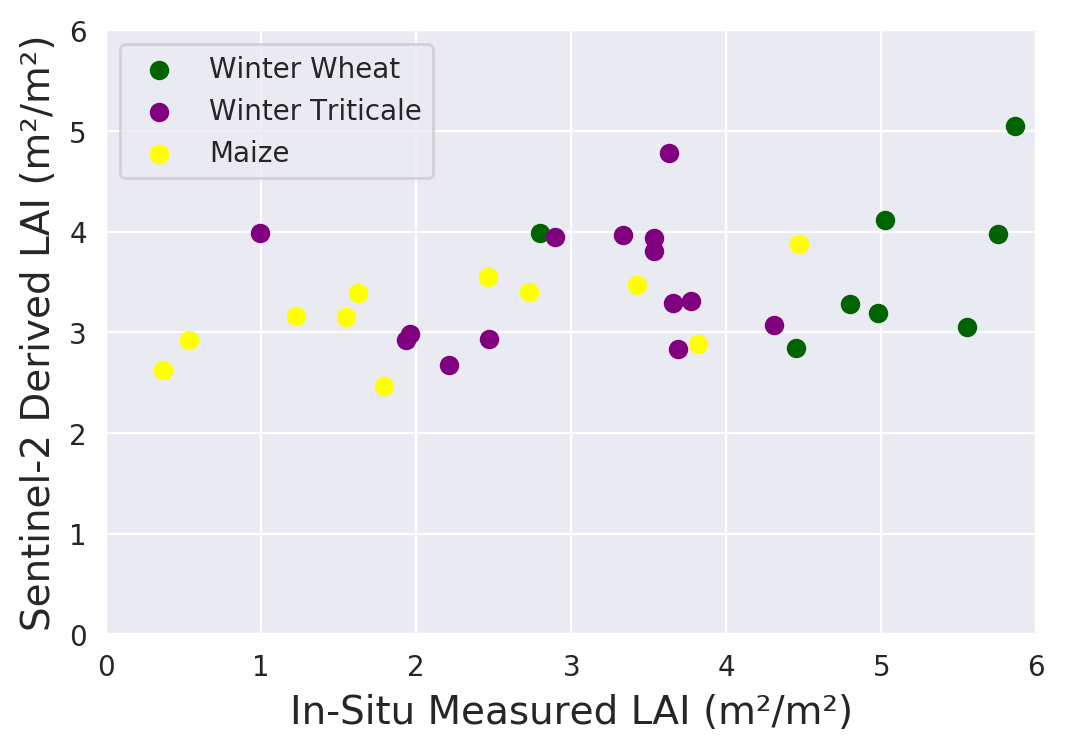

In [12]:
# define function to select the data field-wise
def get_lai_per_field(field_id):
    """returns in-situ and S2 derived LAI values for field parcels"""
    query = """
        SELECT
            insitu_lai, sentinel2_lai
        FROM
            validation.s2_lai_validation
    WHERE
        object_id in ({});
    """.format(field_id)
    cursor.execute(query)
    res = pd.DataFrame(cursor.fetchall())
    res.columns = ['In-Situ LAI', 'Sentinel-2 LAI']
    return res

# query the data for the crop types and put them together in one color-coded scatterplot
ww = get_lai_per_field("508")
wt = get_lai_per_field("301, 542")
ma = get_lai_per_field("319, 515")

sns.set_style('darkgrid')
f = plt.figure(dpi=200)
ax = f.add_subplot(111)
ax.scatter(ww['In-Situ LAI'], ww['Sentinel-2 LAI'], color='darkgreen', label='Winter Wheat')
ax.scatter(wt['In-Situ LAI'], wt['Sentinel-2 LAI'], color='purple', label='Winter Triticale')
ax.scatter(ma['In-Situ LAI'], ma['Sentinel-2 LAI'], color='yellow', label='Maize')
ax.set_ylim(0, 6)
ax.set_xlim(0, 6)
ax.set_ylabel('Sentinel-2 Derived LAI (m²/m²)', fontsize=14)
ax.set_xlabel('In-Situ Measured LAI (m²/m²)', fontsize=14)
ax.legend()

------------------------------------------------------------------------------------------------------------------------

**Time Series Analysis**

As the scatter plot only contains limited information about the temporal and crop type specific characteristics of the LAI development, it seems to be more meaningful to compare the in-situ measured LAI per field in terms of average LAI and its standard deviation to the Sentinel-2 derived LAI per field. This reveals the gaps between the in-situ and satellite derived LAI data and shows at which points in time the temporal patterns were similar and at which points they differed.

Therefore, timeseries plots are generated for each field:

In [8]:
def plot_ts4val(field_id, crop_type, ylim_lower, ylim_upper):
    """
    plots LAI time series using in-situ data (average and standard deviation
    per date) and Sentinel-2 derived data for each field
    """
    query = "select to_date(insitu.date,'MM-DD-YYYY')::DATE, avg(insitu.lai) "\
            "as insitu_lai, stddev(insitu.lai) as insitu_lai_std "\
            "from validation.multiply_lai_2017 as insitu "\
            "where insitu.id = {} AND  insitu.lai >= 0 "\
            "group by to_date(insitu.date,'MM-DD-YYYY')::DATE "\
            "order by to_date(insitu.date,'MM-DD-YYYY')::DATE;".format(
                    field_id)
    con, cursor = connect_db()  # open database connection
    cursor.execute(query)
    # read in the in situ data
    insitu = pd.DataFrame(cursor.fetchall())
    insitu.columns = ['Date', 'Average', 'STD']

    # query the Sentinel-2 derived data
    query = "select inversion.acquisition_date, inversion.lai as sentinel2_lai "\
            "from obia4rtm_sentinel_2.s2_lai_view as inversion "\
            "where inversion.object_id = {} order by "\
            "inversion.acquisition_date;".format(field_id)
    cursor.execute(query)
    # read in the in situ data
    s2 = pd.DataFrame(cursor.fetchall())
    s2.columns = ['Date', 'LAI']

    # plot the time series data
    sns.set_style('darkgrid')
    f2 = plt.figure(dpi=300)
    ax = f2.add_subplot(111)
    ax.fill_between(insitu['Date'],
                    insitu['Average'] - insitu['STD'],
                    insitu['Average'] + insitu['STD'],
                    label='Std in-situ LAI (m²/m²)')
    ax.plot(insitu['Date'], insitu['Average'],
            label='Avg in-situ LAI (m²/m²)', linestyle='dashed', marker='o',
            color='darkred')
    ax.plot(s2['Date'], s2['LAI'],label='S2 LAI (m²/m²)', linestyle='None',
            marker='D', color='darkgreen')
    f2.autofmt_xdate()
    ax.set_xlabel('Date (YYYY-MM)')
    ax.set_ylim(ylim_lower, ylim_upper)
    ax.set_ylabel('LAI (m²/m²)')
    ax.set_title('Field-ID: {0} ({1})'.format(field_id, crop_type))
    ax.legend()
    close_db_connection(con, cursor)

#### Winter Wheat

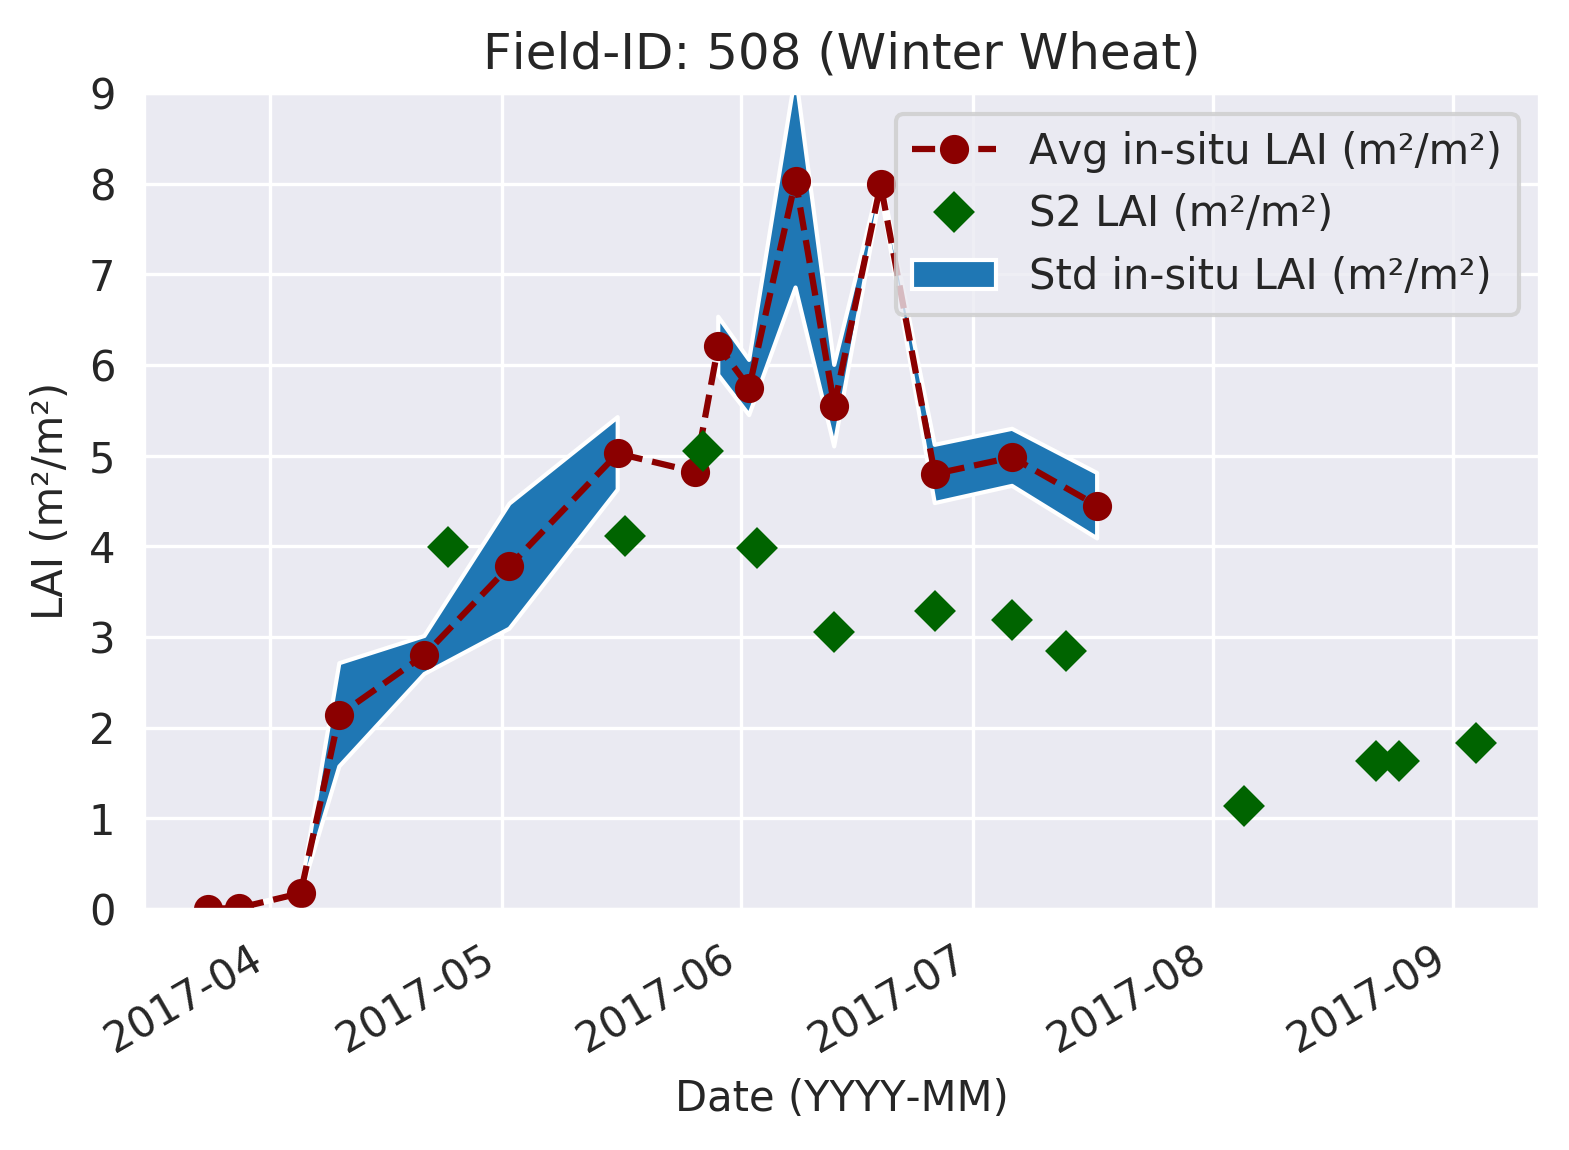

In [10]:
# plot 508
plot_ts4val(508, "Winter Wheat", 0, 9)

At the beginning of the vegetation period, no satellite-derived information is available. In May, there is a good agreement between the in-situ and Sentinel-2 derived LAI values. In June and July, however, the satellite-observed values are lower than those reported in-situ. As the in-situ measurements reported LAI of 8 m²/m² in July, it is questionable whether these numbers are plausible since most winter wheat canopies tend to have values not higher than 7 m²/m².

------------------------------------------------------------------------------------------------------------------------

#### Winter Triticale

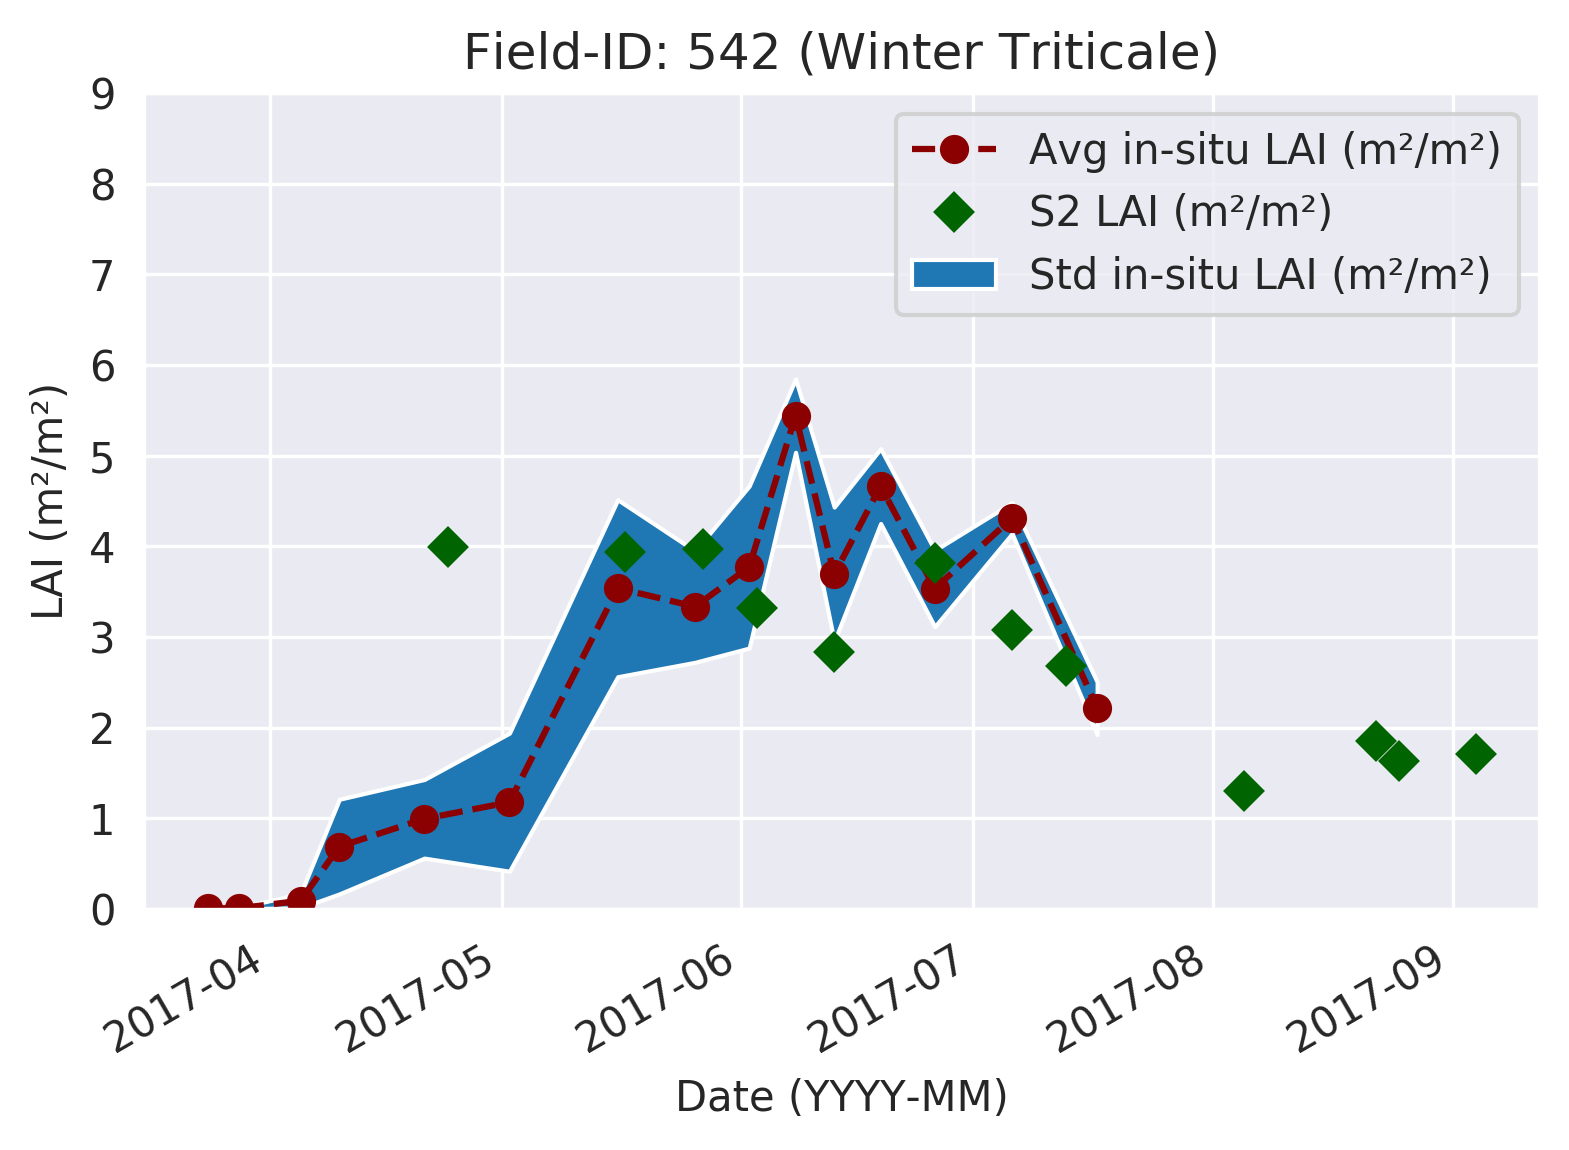

In [11]:
# plot 542
plot_ts4val(542, "Winter Triticale", 0, 9)

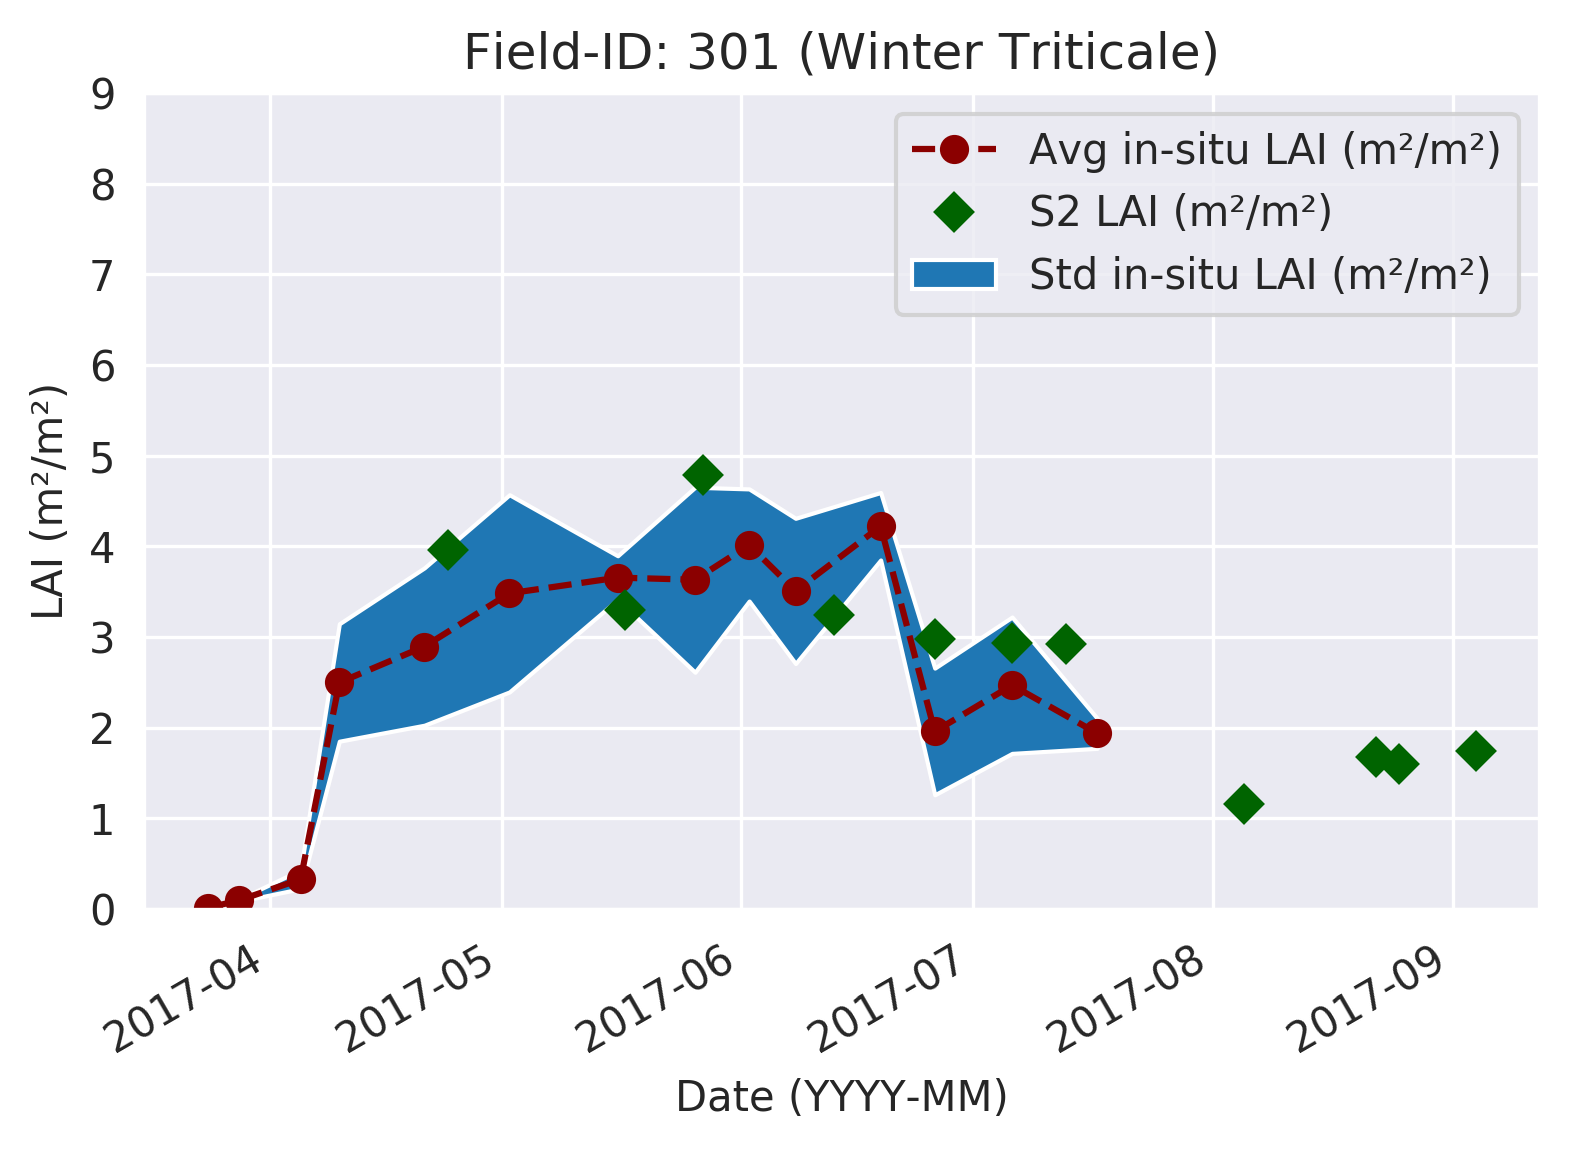

In [12]:
# plot 301
plot_ts4val(301, "Winter Triticale", 0, 9)

For the two winter triticale plots (that were treated as winter wheat) in-situ and Sentinel-2 derived values are in good overall agreement as the Sentinel-2 derived LAI values per field object are within the observed range of LAI values. Thus, in case of winter triticale, the approach revealed promising opportunities.

------------------------------------------------------------------------------------------------------------------------

#### Maize Silage

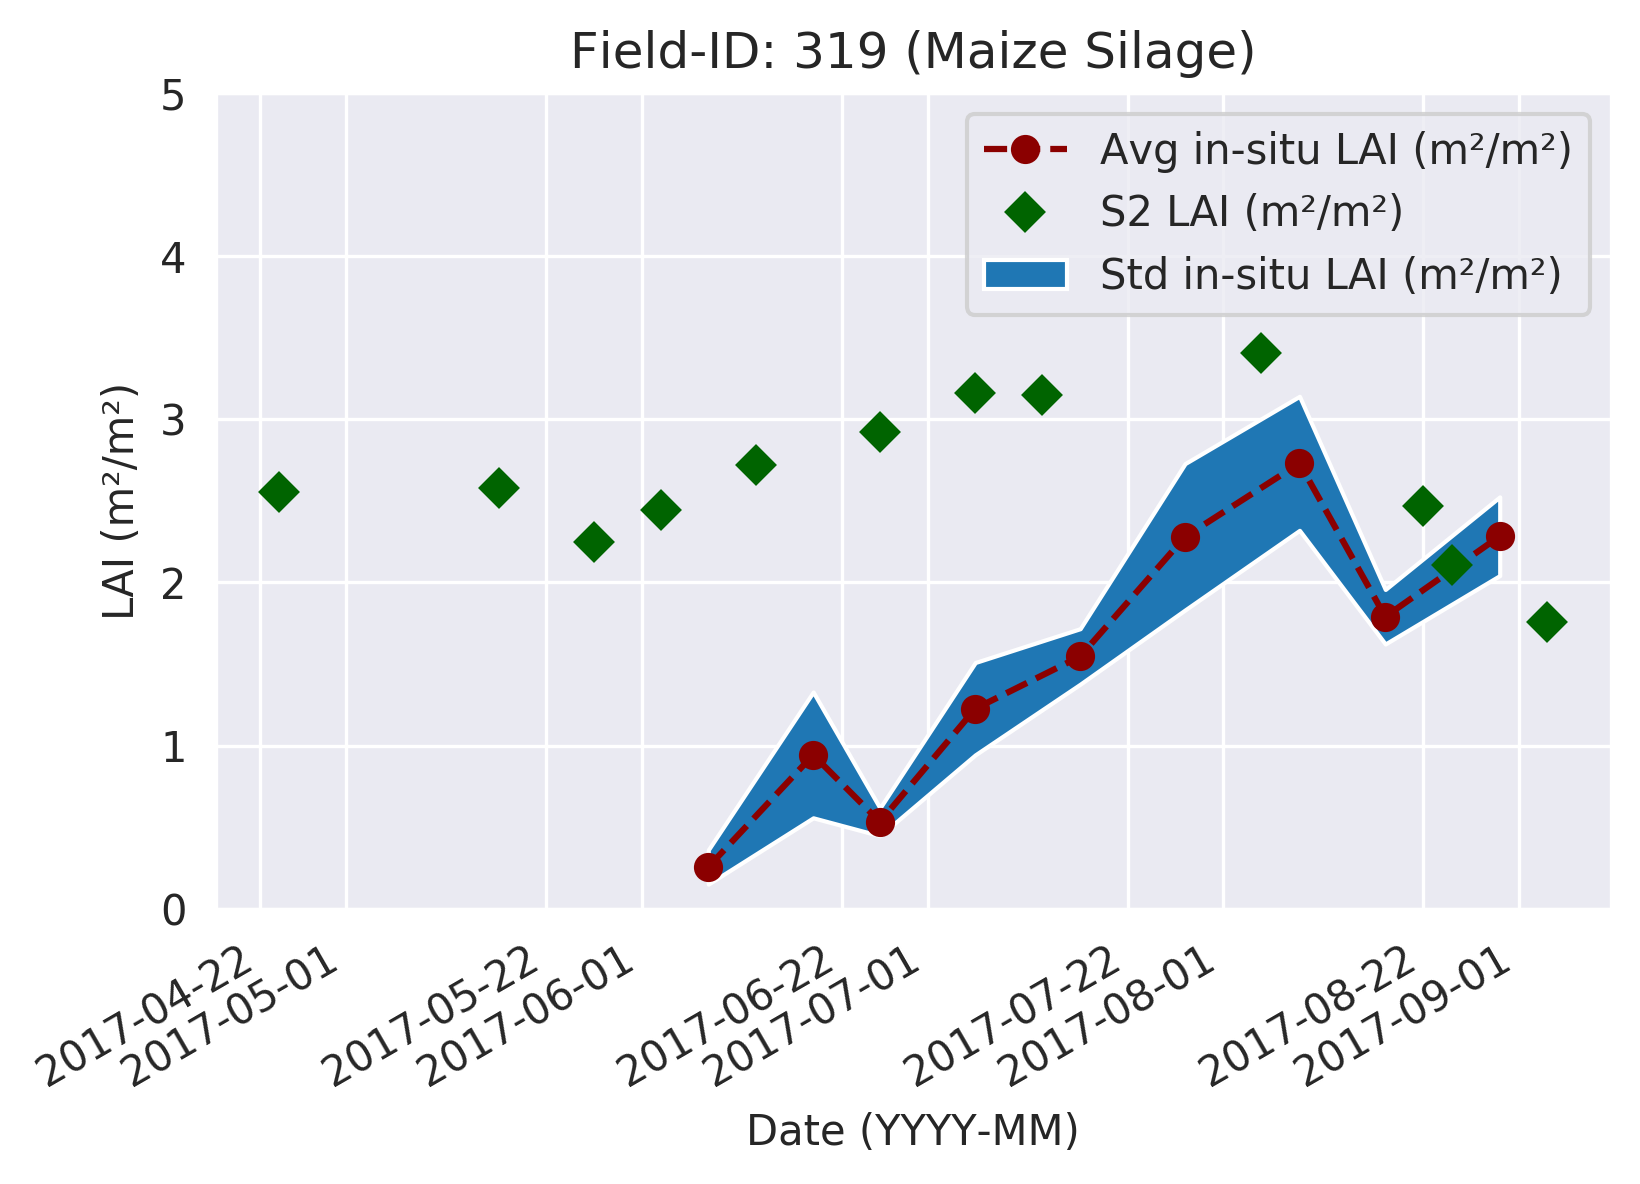

In [13]:
# plot 309
plot_ts4val(319, "Maize Silage", 0, 5)

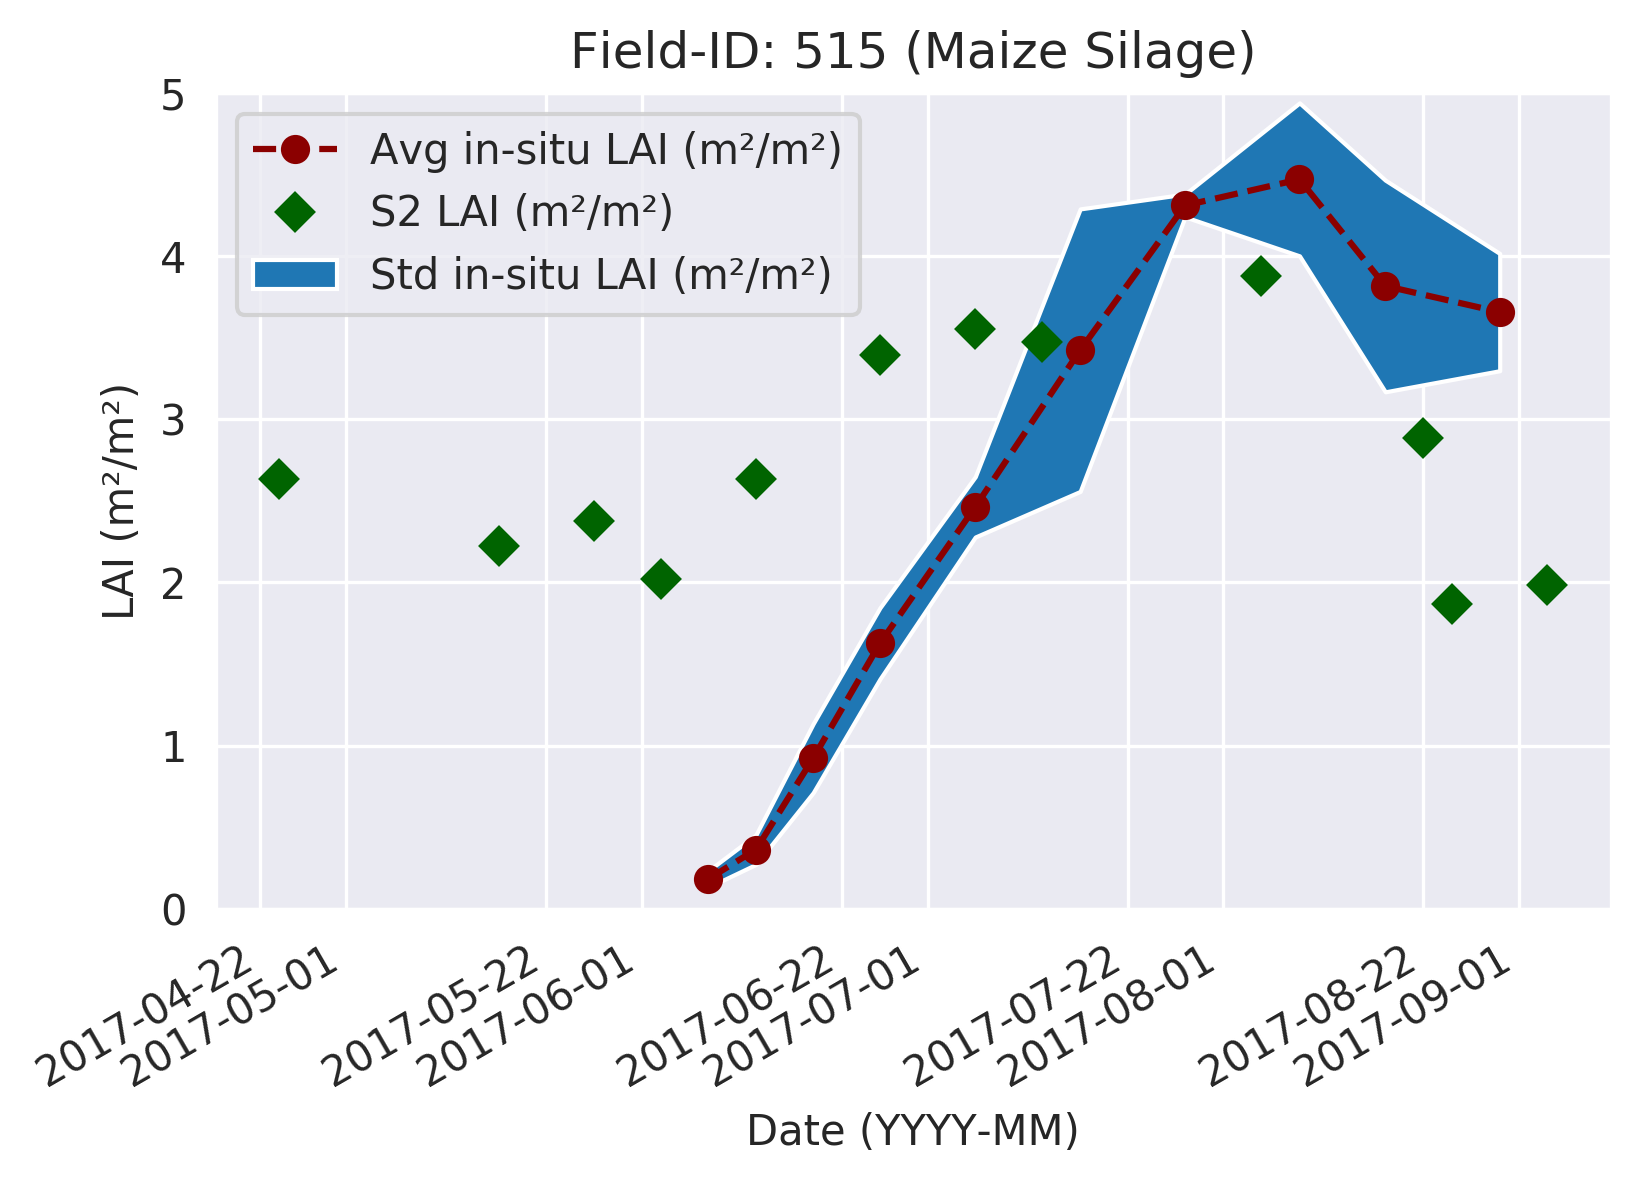

In [14]:
# plot 515
plot_ts4val(515, "Maize Silage", 0, 5)

#### Interactive Web Map showing derived LAI values over time

In this folium web map, the development of Sentinel-2 derived LAI values over time is shown. It uses the Sentinel-2 LAI deliverable available at Github and makes a time series based map that shows the LAI of the five field plots changing over time. Therefore, some data processing is necessary to fit the timestamped geojson format:

In [5]:
import branca.colormap as cm
import geopandas as gpd
from folium.plugins import TimestampedGeoJson
from shapely.geometry import shape


# download data from github
url = r"https://raw.githubusercontent.com/lukasValentin/OBIA4RTM/master/Examples/data/GEOJSON/lai_sentinel-2_multiply2017_wgs84.geojson"
request = requests.get(url)
# read as json
data = request.json()
features = data['features']
# read the geometry information
for d in features:
    d['the_geom'] = shape(d['geometry'])

# construct the geodataframe
gdf = gpd.GeoDataFrame(features).set_geometry('the_geom')

# etract the object_id, date and lai information and better accessible format
gdf['object_id'] = ''
gdf['date'] = None
gdf['lai'] = None
gdf['color'] = None
for idx, row in gdf.iterrows():
    row['object_id'] = row['properties']['object_id']
    row['date'] = pd.to_datetime(row['properties']['acquisition_date'])
    row['lai'] = row['properties']['lai']
    # set the color according to the LAI value
    if row['lai'] <= 1.0:
        row['color'] = '#d7191c'
    elif row['lai'] > 1.0 and row['lai'] <= 2.0:
        row['color'] = '#fdae61'
    elif row['lai'] > 2.0 and row['lai'] <= 3.0:
        row['color'] = '#ffffbf'
    elif row['lai'] > 3.0 and row['lai'] <= 4.0:
        row['color'] = '#a6d96a'
    elif row['lai'] > 4.0 and row['lai'] <= 5.0:
        row['color'] = '#a6d96a'
    else:
        row['color'] = '#fffff'

# drop geojson information not used any longer
gdf = gdf.drop(['type'], axis=1)
gdf = gdf.drop(['properties'], axis=1)


# reformat the data to fit the folium/ geojson timestamp format
def create_geojson_features(df):
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'MultiPolygon', 
                'coordinates':  row['geometry']['coordinates']
            },
            'properties': {
                'time': pd.to_datetime(row['date'], unit='d').__str__(),
                'style': {'color' : row['color'.__str__()],
                'fillOpacity' : 1.0}
                }
            }
        features.append(feature)
    return features

features = create_geojson_features(gdf)

# create a folium map instance
m = folium.Map(location=[48.28, 11.7], zoom_start=13)

TimestampedGeoJson(features,
                  period = 'P1W',
                  duration = 'P1M',
                  transition_time = 1000,
                  loop=False,
                  loop_button=True,
                  date_options='YYYY/MM/DD',
                  auto_play = False).add_to(m)

# add a color legend
cm1 = pd.np.array(['#d7191c','#fdae61','#ffffbf','#a6d96a','#a6d96a'])
colormap = cm.LinearColormap(cm1, index=None, vmin=0.0, vmax=5.0, caption='Sentinel-2 LAI (m²/m²)')
m.add_child(colormap)

# display the map
m
# save the html
# m.save('s2_lai_timeseries.html')

In case of the two maize silage fields the Sentinel-2 derived LAI values were remarkably higher than those values observed in-situ. This could be caused by either an insufficient ProSAIL model parameterization and by the fact the in-situ data does not include weeds that are present in the satellite imagery. For the time from August onwards, however, a good agreement between in-situ and Sentinel-2 derived LAI values can be reported.

------------------------------------------------------------------------------------------------------------------------

### Evaluation of the Validation Results

In the results above we have seen that the proposed OBIA4RTM approach worked well in some cases (especially winter triticale) then in others (especially maize).

In the following table, the main results are summarized and short possible explainations are given for the observed (mis-) matches between the in-situ measured LAI values and the satellite derived LAI:

In [34]:
from IPython.display import HTML, display

display(HTML(
    """
    <table bgcolor="#00FF00", style="width:80%;font-size:100%">
        <tr>
            <th style="text-align:center;">Crop Type</th>
            <th style="text-align:center;">Possible Explaination</th>
        </tr>
        <tr>
            <td style="background-color:darkred;color:white;text-align:center;">Maize Silage</td>
            <td style="text-align:left;">
                <li type="circle">Maize canopies are relatively complex due to their vertical structure and the brown layer on top of the canopy</li>
                <li type="circle">The used ProSAIL model is most likely not capable to resolve this issue as it is a simple 2d model</li>
                <li type="circle">Weeds that were measured in-situ might be present and cause higher LAI values especially at the beginning</li>
            </td>
        </tr>
        <tr>
            <td style="background-color:orange;color:white;text-align:center;">Winter Wheat</td>
            <td style="text-align:left;">
                <li type="circle">OBIA4RTM derived LAI values were lower than the in-situ measured</li>
                <li type="circle">This could be because of inadquate parameterization of the wheat canopy in ProSAIL</li>
                <li type="circle">or be caused by errors in the in-situ data as the high LAI values are probably unrealistically high</li>
            </td>
        </tr>
        <tr>
            <td style="background-color:yellowgreen;color:white;text-align:center;">Winter Triticale</td>
            <td style="text-align:left;">
                <li type="circle">OBIA4RTM derived LAI values were in overall good agreement to the in-situ measured</li>
                <li type="circle">Parameterization of winter triticale in the ProSAIL model seems to be sufficient</li>
            </td>
        </tr>
    </table> 
    """       
))    

Crop Type,Possible Explaination
Maize Silage,Maize canopies are relatively complex due to their vertical structure and the brown layer on top of the canopy The used ProSAIL model is most likely not capable to resolve this issue as it is a simple 2d model Weeds that were measured in-situ might be present and cause higher LAI values especially at the beginning
Winter Wheat,OBIA4RTM derived LAI values were lower than the in-situ measured This could be because of inadquate parameterization of the wheat canopy in ProSAIL or be caused by errors in the in-situ data as the high LAI values are probably unrealistically high
Winter Triticale,OBIA4RTM derived LAI values were in overall good agreement to the in-situ measured Parameterization of winter triticale in the ProSAIL model seems to be sufficient


Of course, there is always room for improvement: However, the results displayed in the table above already indicate that some of the disagreement between in-situ and satellite derived LAI values could be caused by

- ProSAIL model parameterizations inadequat to capture the development of the crops
- the satellite might see also weeds that increase the LAI per field plot; these weeds, however, were not measured during the field campaign
- the proposed approach works on a **per field base**, the samples were **point-based**; thus, it is likely that in case of very heterogenous fields the approach fails as the image object (i.e. the field plot) not comply with the actual level of heterogenity
- thus, also an adequat selection of image objects and careful analysis of them is crucial

# 6) Further Quality Assessment <a name="sixth-bullet"></a>

The previous section showed some outcomes of the validation of the derived LAI values. The advantage of the proposed approach of using RTM for inverting satellite spectra, however, also offers further quality assessment tools as it is possible to have a look at the closest match between simulated and observed spectra.

These allow to evaluate and adopt the parameterization of the ProSAIL model as it is feasible to analyse which parts of the electromagnetic spectrum were modelled accordingly and which not. For instance, if the chlorophyll parameterization of the plants within the ProSAIL model was inadequat then the visible spectral bands will most likely show a relatively large disagreement between the observed and found closest simulated spectra:

We can do this for example using one winter triticale and one maize spectrum selected from the database:

In [10]:
# query the Sentinel-2 central band widths (um) from the OBIA4RTM database
query = "select central_wvl from s2_bands where sensor = 'S2A' order by central_wvl;"
cursor.execute(query)
bands = cursor.fetchall()
bands = [x[0] for x in bands]
bands

[492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 864.7, 1613.7, 2204.4]

In [32]:
# define a function for plotting
def plot_spectra(field, acqui_date, bands):
    """plots inverted and observed satellite spectra"""
    query = """
    select
        (inversion.inversion_results ->> 'B2')::double precision as inv_b2,
        (inversion.inversion_results ->> 'B3')::double precision as inv_b3,
        (inversion.inversion_results ->> 'B4')::double precision as inv_b4,
        (inversion.inversion_results ->> 'B5')::double precision as inv_b5,
        (inversion.inversion_results ->> 'B6')::double precision as inv_b6,
        (inversion.inversion_results ->> 'B7')::double precision as inv_b7,
        (inversion.inversion_results ->> 'B8A')::double precision as inv_b8a,
        (inversion.inversion_results ->> 'B11')::double precision as inv_b11,
        (inversion.inversion_results ->> 'B12')::double precision as inv_b12,
        sat.b2 as org_b2,
        sat.b3 as org_b3,
        sat.b4 as org_b4,
        sat.b5 as org_b5,
        sat.b6 as org_b6,
        sat.b7 as org_b7,
        sat.b8a as org_b8a,
        sat.b11 as org_b11,
        sat.b12 as org_b12
    from
        obia4rtm_sentinel_2.s2_inversion_results as inversion,
        obia4rtm_sentinel_2.s2_obj_spectra as sat
    where
        inversion.object_id = sat.object_id
    and
        inversion.object_id = {0}
    and
        inversion.acquisition_date = sat.acquisition_date
    and
        inversion.acquisition_date = '{1}';
    """.format(field, acqui_date)
    cursor.execute(query)
    res = cursor.fetchall()[0]
    # extract the spectra
    inverted = res[0:9]
    observed = res[9:18]
    # plot spectra
    sns.set_style('darkgrid')
    f = plt.figure(dpi=100)
    ax = f.add_subplot(111)
    ax.plot(bands, inverted, label = 'Inverted Spectrum')
    ax.plot(bands, observed, label = 'Observed Spectrum')
    ax.set_xlabel('Sentinel-2 Bands (um)')
    ax.set_ylabel('Spectral Reflectance (%)')
    plt.title("{0}: {1}".format(field, acqui_date))
    ax.legend()
    plt.show()

#### Winter Triticale

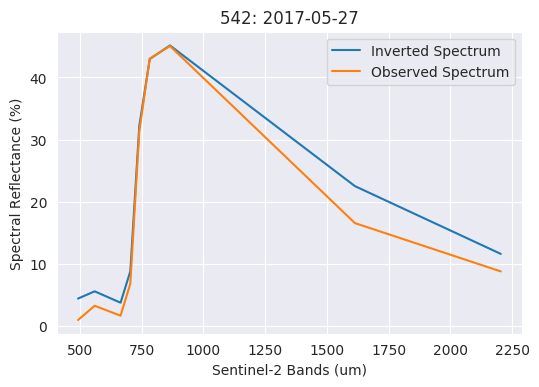

In [33]:
# select a field and a acquisition date
field = 542
acqui_date = '2017-05-27'
plot_spectra(field, acqui_date, bands)

#### Maize Silage

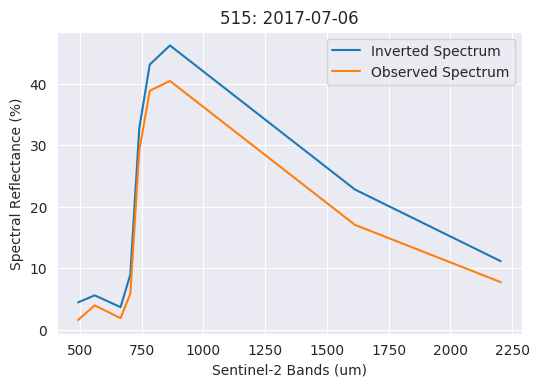

In [34]:
field = 515
acqui_date = '2017-07-06'
plot_spectra(field, acqui_date, bands)

# 7) Do it yourself <a name="eigth-bullet"></a>

You now have seen a lot of examples using data already processed using OBIA4RTM. It is time to do some processing on your own using the **`OBIA4RTM Python Package`** if you are interested. This short tutorial will guide you through a series of steps required to process some Sentinel-2 data on your own and do winter wheat LAI retrieval. Of course, the presented use case can be easily adopted to your own study area etc.

The Gurtenbach catchment and the winter wheat fields are displayed in the web map below. The overall number of field parcels is 501 which is 100 times more than in the previous show case using the Multiply data. It is therefore considered a good demonstrator for scaling up the approach.

In [6]:
m = folium.Map(location=[48.28, 13.35], zoom_start=12)
# include the in-situ data into the leaflet
url = r"https://raw.githubusercontent.com/lukasValentin/OBIA4RTM/master/Examples/data/GEOJSON/2018_Gurtenbach_WinterWheat.geojson"
field_boundaries = json.loads(requests.get(url).text)
# add to leaflet map
ma = folium.GeoJson(# 
    field_boundaries,
    name='Gurtenbach Winter Wheat Parcels 2018',
    style_function=lambda x: {'fillColor':'darkgreen', 'fillOpacity': 0.5}
)
ma.add_to(m)

# dipslay the map
m

To run the following steps make sure to have [OBIA4RTM](https://github.com/lukasValentin/OBIA4RTM) installed on your machine. Therefore, please follow the instructions in the [README](https://github.com/lukasValentin/OBIA4RTM/blob/master/README.md). Moreover, you need a Google Earth Engine account and Python API key to conduct the presented example.

For the set up of the tutorial you need some field boundaries: These were downloaded from the [Austrian Open Government Data Portal](https://www.data.gv.at/) and provide information about the land parcels and their land cover in 2018 ("Invekos-Data"). The data used in this notebook was obtained from [this resource](https://www.data.gv.at/katalog/dataset/e21a731f-9e08-4dd3-b9e5-cd460438a5d9) on Dec 7th 2019 and covers land parcel information for Austria as in 2018. The dataset was clipped to the Gurtenbach catchment located in Upper Austria near the border to Bavaria and filtered for all parcel covered by winter wheat. The catchment has similar climatic and soil conditions as in the Multiply study area. Therefore, it is assumed that the parameterization of ProSAIL applied in the previous sections is also valid for the Gurtenbach study area.

A shapefile containing the clipped and filtered fields (winter wheat only, land code: 2) can be downloaded from [here](https://github.com/lukasValentin/OBIA4RTM/blob/master/Examples/data/2018_Gurtenbach_WinterWheat.zip?raw=true). Extract the shapefile and store it somewhere on your machine.
The ProSAIL parameterization is available [here](https://raw.githubusercontent.com/lukasValentin/OBIA4RTM/master/Examples/data/OBIA4RTM_CFG/prosail.txt). The txt-file should be copied into the OBIA4RTM *home directory* in your user profile (e.g. on Ubuntu: /home/<your_username>/OBIA4RTM/) in order to allow OBIA4RTM to localize and load it correctly.

Now, you can start by loading the **`OBIA4RTM Processing API`**

In [1]:
from OBIA4RTM.processing_api import API

# Google Earth Engine will be used for pre-processing the Sentinel-2 imagery
use_gee = True
# create a new API instance to handle the processing
api = API(use_gee)
# set the tablenames accordingly to allow OBIA4RTM to store the results in the
# PostgreSQL/PostGIS backend database
api.set_tablenames()

# Option for cloud masking and shadow detection after atmospherical correction
# -> use method provided by Sam Murphy (Option = 2)
option = 2

# Shapefile with Gurtenbach winter wheat fields in 2018
shp = r'<your_path>/2018_Gurtenbach_WinterWheat.shp'

After the modules are loaded, the pre-processing can start. In this tutorial, the area of the Gurtenbach catchment will be processed for the 21st May 2018 as this acquisition date was completely cloud free. The Sentinel-2 data will be corrected for atmospheric effects using **`Py6S`** and stored as mean per-object surface reflectance for each winter wheat plot. This might take a while as currently no parallel processing facilities are supported:

In [ ]:
# demonstrate the up-scaling capacities of OBIA4RTM by processing data at the
# catchment level for one acquistion date using the Gurtenbach catchment as an
# area with similar climate and soils as in the Multiply area. Agricultural
# fields are derived from Land Parcel Information System available for Austria
# at https://www.data.gv.at/katalog/dataset/e21a731f-9e08-4dd3-b9e5-cd460438a5d9
# (accessed last on 7th Dec 2019)
# define a bounding box covering the Gurtenbach catchment
geom = [[13.24668939674848,48.180705394317606],
        [13.454742985615667,48.180705394317606],
        [13.454742985615667,48.329288739856565],
        [13.24668939674848,48.329288739856565],
        [13.24668939674848,48.180705394317606]]

# get the atmospherically corrected spectra on a per object-base (might take longer!)
scene_id = api.do_gee_preprocessing(geom,
                                    acqui_date,
                                    option,
                                    shp)


During processing, you can check the log files to ensure that everything is working as expected. In the log file you find information about the atmospheric correction:

2019-12-07 10:57:05,243 - OBIA4RTM_Logger - INFO - Starting Processing scene 'S2B_OPER_MSI_L1C_DS_MTI__20180521T115717_S20180521T100628_N02.06' using GEE and Py6S

2019-12-07 10:57:09,080 - OBIA4RTM_Logger - INFO - Atcorr-Metadata: Water-Vapor = 1.3800000190734862, Ozone = 0.355, AOT = 0.20233333110809326,  Average Altitude (m) = 458.0

2019-12-07 10:57:09,084 - OBIA4RTM_Logger - INFO - Calculating cloud and shadow mask

2019-12-07 10:57:09,107 - OBIA4RTM_Logger - INFO - Finished calculating cloud and shadow mask

2019-12-07 10:57:09,109 - OBIA4RTM_Logger - INFO - 6S: Starting processing of Sentinel-2 scene!

2019-12-07 10:57:10,969 - OBIA4RTM_Logger - INFO - 6S: Finished processing Sentinel-2 Band 2!

2019-12-07 10:57:12,085 - OBIA4RTM_Logger - INFO - 6S: Finished processing Sentinel-2 Band 3!

2019-12-07 10:57:13,188 - OBIA4RTM_Logger - INFO - 6S: Finished processing Sentinel-2 Band 4!

2019-12-07 10:57:13,927 - OBIA4RTM_Logger - INFO - 6S: Finished processing Sentinel-2 Band 5!

2019-12-07 10:57:14,664 - OBIA4RTM_Logger - INFO - 6S: Finished processing Sentinel-2 Band 6!

2019-12-07 10:57:15,400 - OBIA4RTM_Logger - INFO - 6S: Finished processing Sentinel-2 Band 7!

2019-12-07 10:57:16,482 - OBIA4RTM_Logger - INFO - 6S: Finished processing Sentinel-2 Band 8A!

2019-12-07 10:57:17,564 - OBIA4RTM_Logger - INFO - 6S: Finished processing Sentinel-2 Band 11!

2019-12-07 10:57:18,643 - OBIA4RTM_Logger - INFO - 6S: Finished processing Sentinel-2 Band 12!

2019-12-07 10:57:18,645 - OBIA4RTM_Logger - INFO - 6S: Finished processing of Sentinel-2 scene!

And you will also get information why an object was not processed: E.g. because of not meeting the size constraint or being covered by clouds or by blackfill:

2019-12-07 11:23:16,449 - OBIA4RTM_Logger - INFO - No spectral information found for Object with ID 1668205

2019-12-07 11:23:16,452 - OBIA4RTM_Logger - WARNING - The object 1668360 was too small compared to the spatial resolution of Sentinel-2! Object area (m2): 1181.571049299222; Minimum area required (m2): 2400 -> skipping

After that, the per-object spectra are stored in the OBIA4RTM database. Next, you can do the **`inversion`** in order to retrieve LAI values using ProSAIL. Therefore, construct the lookup table with synthetic reference spectra and compare the spectra to those derived from Sentinel-2 and find the average of e.g. the 10 best matches in terms of the lowest RMSE. Store the results in the database.

**`Please note`**:
To **avoid long computation times** apply some changes to the downloaded ProSAIL config file and the shapefile with the winter wheat fields

- in the **shapefile** alter the value of the column *LU20180521* in the attribute table from "2" to "0"
- in the **ProSAIL config file** in your OBIA4RTM home directory delete the first two parameterizations for the *bare soil* and *maize* land cover class since there is none of them in the current setting

This changes are necessary, since the current setup of OBIA4RTM lacks some flexibility and a more intelligent setup of the land cover classes for running ProSAIL. Otherwise, also the LUT for bare soil and maize will be created that only adds an additional computational burden to the model that is absolutely unnecessary. In future releases of OBIA4RTM this behaviour might be changed.

In [ ]:
# use the best 10 solutions (mean)
num_best_solutions = 10
# do the inversion for the LUT classes 0 (bare soil) 1 (maize silage) and 2 (winter wheat)
luc_classes = [0, 1, 2]
# get an instance of the inversion interface provided by processing API
# and run it; return the inverted spectra
# this might also take a while
status = api.do_inversion(scene_id, num_best_solutions, luc_classes,
                     return_specs=True)